In [62]:
# Created on jan 2025
# https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1012692

# numpy and scipy
import numpy as np
import scipy.stats as stt
import scipy.linalg as spl
import scipy.signal as spsg
import scipy.io as sio


# MOU model
from test_MOU_largenet import MOUv2

# classification scikit-learn
import sklearn.linear_model as skllm
import sklearn.preprocessing as skppr
import sklearn.pipeline as skppl
import sklearn.neighbors as sklnn

# plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sb
import pandas as pd

#saving results
import os


# Empirical data

In [63]:
import os

data_dir = './' # data repo
res_dir = './results_1104_caos/' # results
os.makedirs(res_dir, exist_ok=True)
graph_format = 'png' # graph formatting


# data and model parameters
n_sub = 48
#Change
conds = ['CTR', 'SCZ']
n_cond = len(conds) # number of conditions

N = 68 # size of network for AAL90

In [64]:
TS_CTR  = np.load('./TS_Control.npy')
TS_SCZ  = np.load('./TS_Schizo.npy')

In [65]:

# Example input array of shape (180, 718, 36)
#original_array = TS

# Separate the participants by condition
condition_0 = TS_CTR[0:48, 0:68, :]  # all participants (condition 0)
condition_1 = TS_SCZ[:, 0:68, :]  # Last 48 participants (condition 1)

# Determine the maximum number of participants in either condition (for alignment)
max_participants = max(condition_0.shape[2], condition_1.shape[2])

# Pad the smaller group to match the size of the larger one along the participant dimension
condition_0_padded = np.pad(condition_0, ((0, 0), (0, 0), (0, max_participants - condition_0.shape[2])), mode='constant')
condition_1_padded = np.pad(condition_1, ((0, 0), (0, 0), (0, max_participants - condition_1.shape[2])), mode='constant')

# Stack the conditions along the fourth dimension
new_array_original = np.stack((condition_0_padded, condition_1_padded), axis=3)

print("New array shape:", new_array_original.shape)

n_sub = 47

New array shape: (48, 68, 152, 2)


In [66]:
# Define indices to remove
indices_to_remove = {0: 19, 1: 11}

# Use list comprehension to filter out the indices for each condition
new_array = np.stack([
    new_array_original[np.arange(48) != indices_to_remove[0], :, :, 0],  # Remove index 19 for condition 0
    new_array_original[np.arange(48) != indices_to_remove[1], :, :, 1]   # Remove index 11 for condition 1
], axis=-1)

print(new_array.shape)  # Should be (47, 68, 152, 2)

(47, 68, 152, 2)


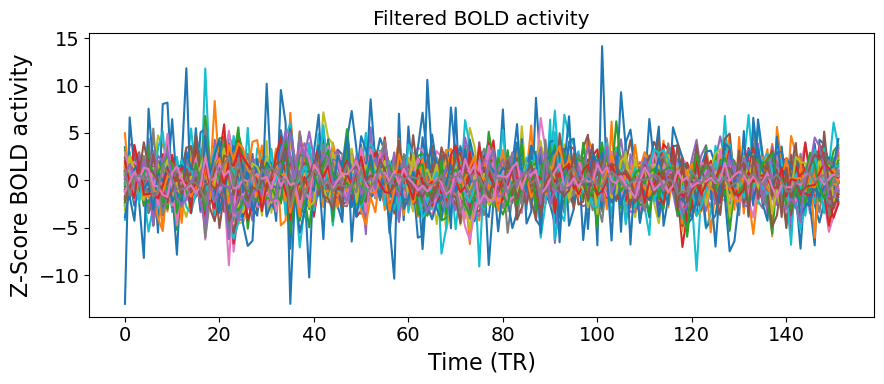

In [67]:
#All data plotted are stored in new_array
plt.figure(figsize=(9,4))
plt.plot(range(new_array.shape[2]), new_array[1,:,:,1].T)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Time (TR)', fontsize=16)
plt.ylabel('Z-Score BOLD activity', fontsize=16)
plt.title("Filtered BOLD activity")
plt.tight_layout()

# MOU fitting to fMRI data

In [68]:
lim_FC = np.full((48, 2), 0.1)

'''
#outliers
lim_FC[11, 1] = 0.05
lim_FC[19, 0] = 0.05
'''
#good changes
lim_FC[23, 1] = 0.2
lim_FC[18, 1] = 0.2
lim_FC[45, 0] = 0.2
lim_FC[11, 0] = 0.3
lim_FC[45, 0] = 0.3
lim_FC[45, 1] = 0.2

'''
EPR is high: [15, 1]
EPR is high: [24, 1]
'''
lim_FC[15, 1] = 0.1
lim_FC[24, 1] = 0.1


In [69]:
# using new_array where all data are stored:

import numpy as np
import scipy.io as sio
import scipy.linalg as spl

min_val_EC = 0.0  # minimal value for EC
max_val_EC = 1.0  # maximal value for EC
min_val_Sigma = 0.0  # minimal value for Sigma

n_sub = 47
n_cond = 2
N = 68

# arrays to store results
var_BOLD = np.zeros([n_sub, n_cond, N])  # empirical BOLD variance
J_mod = np.zeros([n_sub, n_cond, N, N])  # model Jacobian (EC)
Sigma_mod = np.zeros([n_sub, n_cond, N, N])  # model Sigma
FC0_mod = np.zeros([n_sub, n_cond, N, N])  # model zero-lag FC
err_mod = np.zeros([n_sub, n_cond])  # model error
fit_mod = np.zeros([n_sub, n_cond])  # model goodness of fit (Pearson corr)

# load structural connectivity and create anatomical mask
SCR = sio.loadmat('./SC_EnigmadK68.mat')['matrix']
SC = SCR / np.max(SCR)
lim_SC = 0.95

# anatomy-derived mask (constant across subs/conds)
mask_ECS = np.zeros([N, N], dtype=bool)
mask_ECS[SC > lim_SC] = True
for i in range(N):
    mask_ECS[i, i] = False
    mask_ECS[i, N - 1 - i] = True  # interhemispheric connections

print('network size:', N)
print('EC density:', mask_ECS.sum() / float(N * (N - 1)))

# diagonal mask for input noise matrix (so far, tune noise matrix for diagonal elements only)
mask_Sigma = np.eye(N,dtype=bool)
regul_Sigma = 0.0

# precompute FC-based and combined EC masks
mask_ECF_all = np.zeros([n_sub, n_cond, N, N], dtype=bool)
mask_EC_all = np.zeros([n_sub, n_cond, N, N], dtype=bool)

for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        ts = new_array[i_sub, :, :, i_cond]
        var_BOLD[i_sub, i_cond, :] = ts.var(axis=1)

        FC0 = np.corrcoef(ts)
        FC1 = FC0 / np.max(FC0)

        mask_ECF = np.zeros([N, N], dtype=bool)
        mask_ECF[FC1 > lim_FC[i_sub, i_cond]] = True
        for i in range(N):
            mask_ECF[i, i] = False
            mask_ECF[i, N - 1 - i] = True

        mask_ECF_all[i_sub, i_cond] = mask_ECF
        mask_EC_all[i_sub, i_cond] = np.logical_or(mask_ECS, mask_ECF)

# model fitting loop
for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        ts = new_array[i_sub, :, :, i_cond]

        mou_est = MOUv2()
        mou_est.fit(
            ts.T,
            mask_C=mask_ECF_all[i_sub, i_cond],
            mask_Sigma=mask_Sigma,
            algo_version='true',
            min_iter=5,
            max_iter=20,
            epsilon_C=0.005,
            epsilon_Sigma=0.005,
            verbose=False
        )

        J_mod[i_sub, i_cond, :, :] = mou_est.J
        Sigma_mod[i_sub, i_cond, :, :] = mou_est.Sigma
        FC0_mod[i_sub, i_cond, :, :] = spl.solve_lyapunov( J_mod[i_sub, i_cond, :, :].T, -Sigma_mod[i_sub, i_cond, :, :])
        err_mod[i_sub, i_cond] = mou_est.d_fit['distance']
        fit_mod[i_sub, i_cond] = mou_est.d_fit['correlation']

        print(f'sub {i_sub} ; cond {i_cond} : {mou_est.d_fit}', flush=True)


network size: 68
EC density: 0.015364354697102721
Optimization did not converge. Maximum number of iterations arrived.
sub 0 ; cond 0 : {'n_tau': 2, 'iterations': 20, 'distance': np.float64(0.8698993557378484), 'correlation': np.float64(0.5519856480649806), 'distance history': array([0.91027644, 0.90788178, 0.90552969, 0.90321666, 0.90093971,
       0.89869628, 0.89648405, 0.89430111, 0.89214573, 0.89001637,
       0.88791167, 0.88583031, 0.88377124, 0.88173299, 0.87971489,
       0.87771622, 0.87573613, 0.87377378, 0.87182841, 0.86989936]), 'correlation history': array([0.42523869, 0.43323628, 0.44106712, 0.44873591, 0.45624665,
       0.46360297, 0.47080838, 0.4778658 , 0.48477804, 0.49154783,
       0.49817778, 0.50467069, 0.51102885, 0.51725602, 0.52335388,
       0.5293244 , 0.5351702 , 0.54089399, 0.54649837, 0.55198565]), 'distFC0': np.float64(0.8274740968789821), 'distFC1': np.float64(0.9123246145967147)}
Optimization did not converge. Maximum number of iterations arrived.
sub 

Check that each participant has a goodness of fit higher then 0.55

In [70]:
for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        if fit_mod[i_sub,i_cond]< 0.55:
            print(i_sub, i_cond)

1 0
3 0
4 0
4 1
7 1
8 0
9 0
9 1
10 0
10 1
11 0
12 0
16 1
17 1
18 1
19 0
20 0
21 1
23 0
24 0
25 0
26 0
28 1
29 1
30 0
30 1
31 0
33 1
35 1
37 0
38 0
38 1
39 0
40 1
41 1
43 0
45 0
45 1


In [71]:
#%% save results
np.save(os.path.join(res_dir, f'J_mod_try.npy'), J_mod)
np.save(os.path.join(res_dir, f'Sigma_mod_try.npy'), Sigma_mod)
np.save(os.path.join(res_dir, f'FC0_mod_try.npy'), FC0_mod)

np.save(os.path.join(res_dir, f'err_mod_try.npy'), err_mod)
np.save(os.path.join(res_dir, f'fit_mod_try.npy'), fit_mod)

np.save(os.path.join(res_dir, f'var_BOLD_try.npy'), var_BOLD)


## Test goodness of fit

/tmp/ipykernel_30757/1680162601.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(data=err_mod_df, x='cond', y='sum EC', palette=cols)
/tmp/ipykernel_30757/1680162601.py:15: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sb.violinplot(data=err_mod_df, x='cond', y='sum EC', palette=cols)
/tmp/ipykernel_30757/1680162601.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(data=fit_mod_df, x='cond', y='sum EC', palette=cols)
/tmp/ipykernel_30757/1680162601.py:39: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sb.violinplot(data=fit_mod_df, x='cond', y='sum EC', palette=cols)


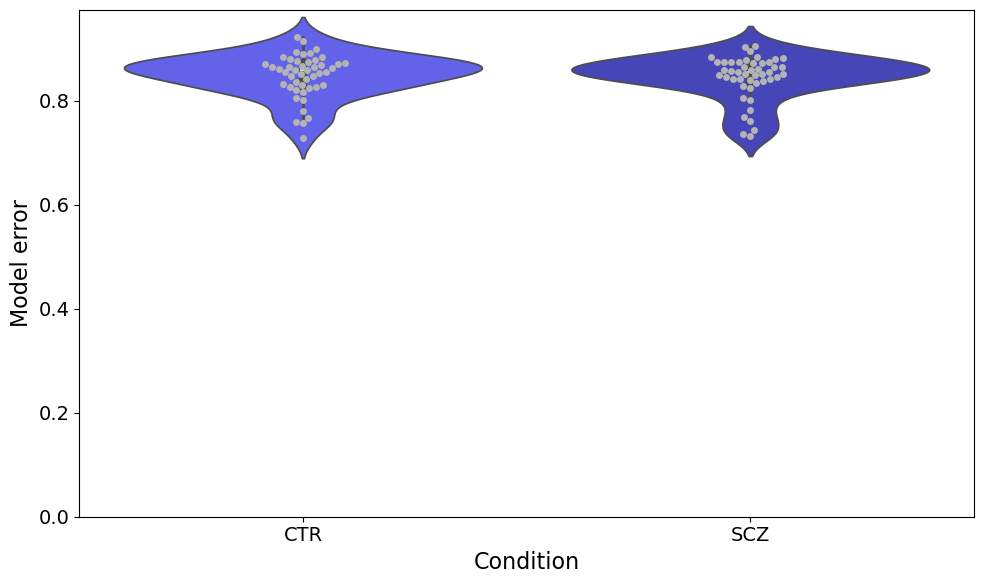

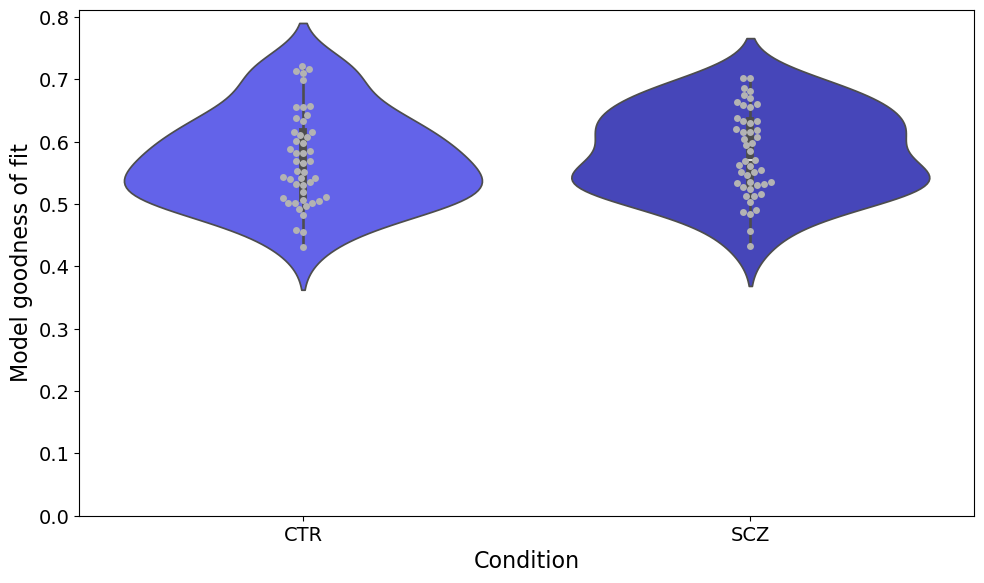

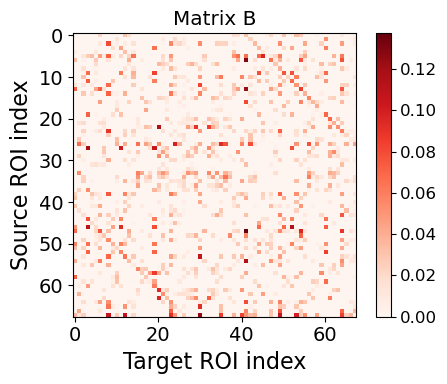

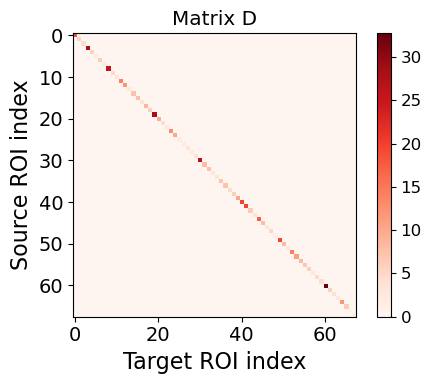

In [72]:
mask_diag = np.eye(N, dtype=bool) # mask for diagonal elements

cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]] # colors

# model error

err_mod_tmp = dict()
err_mod_tmp['sum EC'] = err_mod.flatten()
err_mod_tmp['sub'] = np.repeat(np.arange(n_sub), n_cond).flatten()
err_mod_tmp['cond'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()

err_mod_df = pd.DataFrame(err_mod_tmp)
# Create the figure
plt.figure(figsize=(10, 6))
sb.violinplot(data=err_mod_df, x='cond', y='sum EC', palette=cols)
sb.swarmplot(data=err_mod_df, x='cond', y='sum EC', color=[0.7,0.7,0.7])
plt.axis(ymin=0)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Condition',fontsize=16)
plt.ylabel('Model error',fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(res_dir,f'model_fit_error_try.eps'), format='eps')

# Pearson correlation

fit_mod_tmp = dict()
fit_mod_tmp['sum EC'] = fit_mod.flatten()
fit_mod_tmp['sub'] = np.repeat(np.arange(n_sub), n_cond).flatten()
fit_mod_tmp['cond'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()

fit_mod_df = pd.DataFrame(fit_mod_tmp)


# Create the figure
plt.figure(figsize=(10, 6))
sb.violinplot(data=fit_mod_df, x='cond', y='sum EC', palette=cols)
sb.swarmplot(data=fit_mod_df, x='cond', y='sum EC', color=[0.7,0.7,0.7])
plt.axis(ymin=0)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Condition',fontsize=16)
plt.ylabel('Model goodness of fit',fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(res_dir,f'model_goodness_fit_try.eps'), format='eps')


# Example EC

plt.figure(figsize=(5,4))
plt.imshow(np.maximum(J_mod[0,0,:,:],0), cmap='Reds')   # Show only the non-negatives
#plt.imshow(J_mod[0,0,:,:], cmap='Reds')   # Show only the non-negatives
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Matrix B')
plt.xlabel('Target ROI index', fontsize=16)
plt.ylabel('Source ROI index', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(res_dir,f'example0_EC_try.eps'), format='eps')#Change

# Example EC

plt.figure(figsize=(5,4))
#plt.imshow(np.maximum(Sigma_mod[0,0,:,:],0), cmap='Reds')   # Show only the non-negatives
plt.imshow(Sigma_mod[0,0,:,:], cmap='Reds')   # Show only the non-negatives
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Matrix D')
plt.xlabel('Target ROI index', fontsize=16)
plt.ylabel('Source ROI index', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(res_dir,f'example_EC_try.eps'), format='eps')

# 


In [56]:
# Pearson correlation

fit_mod_tmp = dict()
fit_mod_tmp['sum EC'] = fit_mod.flatten()
fit_mod_tmp['sub'] = np.repeat(np.arange(n_sub), n_cond).flatten()
fit_mod_tmp['cond'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()

fit_mod_df = pd.DataFrame(fit_mod_tmp)



# Calculate Entropy Production of the fitted MOU

In [57]:
# transpose to Saclay's framework
EPR = np.zeros([n_sub,n_cond])
Q_indiv = np.zeros([n_sub,n_cond,N,N])

def is_antisymmetric(A, tol=1e-8):
    if A.shape[0] != A.shape[1]:
        return False  # Must be square
    return np.allclose(A.T, -A, atol=tol)

Q_antisym = np.zeros([n_sub, n_cond], dtype=bool)


for i_sub in range(n_sub):
    for i_cond in range(n_cond):

        try:
            B = np.copy(-J_mod[i_sub,i_cond,:,:].T) # B=-J
            D = np.copy(0.5 * Sigma_mod[i_sub,i_cond,:,:]) # D=1/2 * Sigma
            S = np.copy(FC0_mod[i_sub,i_cond,:,:])
            
            Q = np.dot(B, S) - D
            Q_indiv[i_sub,i_cond,:,:] = Q
            Q_antisym[i_sub, i_cond] = is_antisymmetric(Q)
            
            # sanity check
            if True:
                print('should be close to zero:', np.abs(np.dot(B,S) + np.dot(S,B.T) -2*D).max())
                '''
                it was just to check if I was working with all real matrices and of course I am:
                print(np.iscomplexobj(B))
                print(np.iscomplexobj(D))
                print(np.iscomplexobj(S))
                '''

            # formula from Godreche Luck
            Dinv = np.linalg.pinv(D)
            Sinv = np.linalg.pinv(S)
            
            entropy_prod_rate = -np.trace(np.dot(np.dot(np.dot(Sinv, Q), Dinv), Q))  #-tr(S^(-1)*Q*D^(-1)*Q)
            EPR[i_sub,i_cond] = entropy_prod_rate


        except:
            print('problem with subject/cond:', i_sub, i_cond)
       

np.save(os.path.join(res_dir, f'EPR_try.npy'),EPR)



should be close to zero: 7.872283554199999e-14
should be close to zero: 1.2079226507921703e-13
should be close to zero: 9.947598300641403e-14
should be close to zero: 2.2737367544323206e-13
should be close to zero: 1.9895196601282805e-13
should be close to zero: 6.394884621840902e-14
should be close to zero: 5.813405312693476e-14
should be close to zero: 1.1943224187405121e-13
should be close to zero: 1.3500311979441904e-13
should be close to zero: 8.171241461241152e-14
should be close to zero: 1.0658141036401503e-13
should be close to zero: 1.2551765182777785e-13
should be close to zero: 5.258016244624741e-13
should be close to zero: 3.552713678800501e-13
should be close to zero: 2.0605739337042905e-13
should be close to zero: 6.22002449546244e-14
should be close to zero: 3.126388037344441e-13
should be close to zero: 3.694822225952521e-13
should be close to zero: 5.684341886080802e-14
should be close to zero: 5.115907697472721e-13
should be close to zero: 2.984279490192421e-13
should

Check if there are some strange high EPR values

In [58]:
for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        if abs(EPR[i_sub,i_cond]) > 10: print(f"EPR is high: {[i_sub, i_cond]}")

/tmp/ipykernel_30757/3841950413.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sb.violinplot(data=EPR_df, x='sleep stage', y='EPR', palette=cols)
/tmp/ipykernel_30757/3841950413.py:19: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  ax = sb.violinplot(data=EPR_df, x='sleep stage', y='EPR', palette=cols)


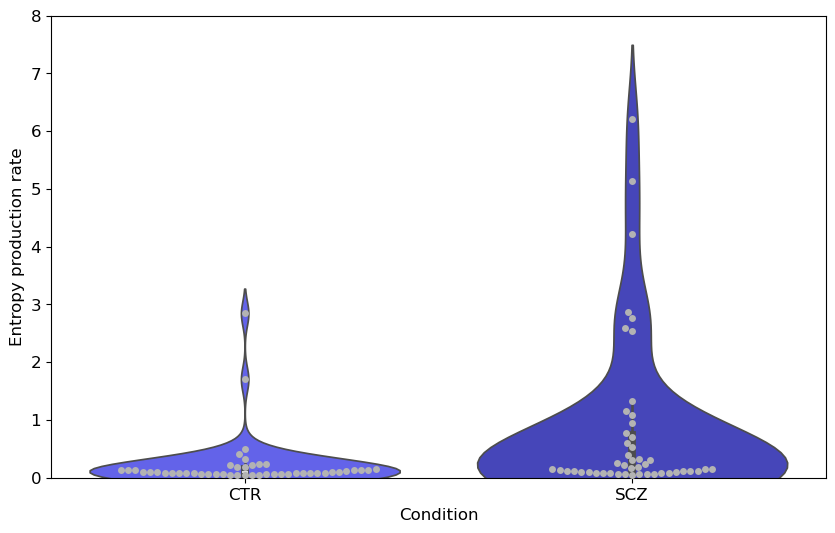

In [59]:
#%% plots

matplotlib.rc('font', size=12) 
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)

cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]]
cols2 = [[0.7,0.7,1],[0.6,0.6,1],[0.5,0.5,1],[0.4,0.4,1]]

EPR_tmp = dict()
EPR_tmp['sleep stage'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()
EPR_tmp['EPR'] = EPR.flatten()

EPR_df = pd.DataFrame(EPR_tmp)

# real data
# Create the figure
plt.figure(figsize=(10, 6))
ax = sb.violinplot(data=EPR_df, x='sleep stage', y='EPR', palette=cols)
sb.swarmplot(data=EPR_df, x='sleep stage', y='EPR', color=[0.7,0.7,0.7])
plt.axis(ymin=0, ymax=8)

plt.xlabel('Condition', fontsize=12)
plt.ylabel('Entropy production rate', fontsize=12)

plt.savefig(os.path.join(res_dir, f'entropy_prod_rate_try.eps'), format='eps')

## Statistical significance test 


Statistical Test Results:
Mann-Whitney U test statistic: 677.00
p-value: 0.001
statistically significant difference between the distributions of the two groups


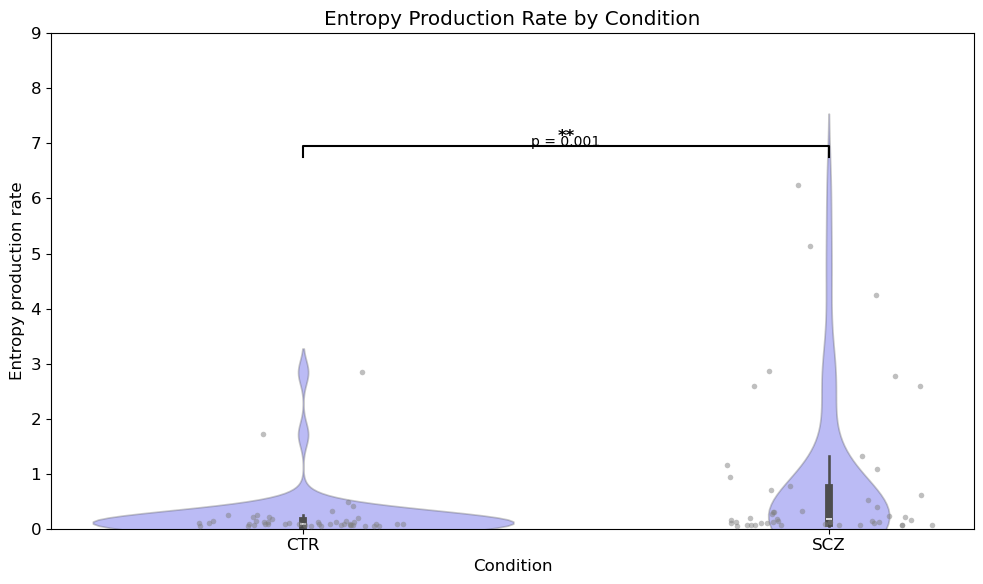

In [23]:
#trial
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Create sample data (replace with your actual data)
data = pd.DataFrame({
    'Condition': ['CTR']*47 + ['SCZ']*47,
    'Entropy_production_rate': np.concatenate([
        EPR_df[EPR_df['sleep stage'] == 'CTR']['EPR'].tolist(),
        EPR_df[EPR_df['sleep stage'] == 'SCZ']['EPR'].tolist()
    ])
})

# Perform statistical test
ctr_data = data[data['Condition'] == 'CTR']['Entropy_production_rate']
scz_data = data[data['Condition'] == 'SCZ']['Entropy_production_rate']

# Perform Mann-Whitney U test (non-parametric test for independent samples)
statistic, p_value = stats.mannwhitneyu(ctr_data, scz_data, alternative='two-sided')

# Create the figure
plt.figure(figsize=(10, 6))

# Create violin plot
sns.violinplot(data=data, 
               x='Condition', 
               y='Entropy_production_rate',
               color='blue',
               alpha=0.3)

# Add strip plot (individual points)
sns.stripplot(data=data,
             x='Condition',
             y='Entropy_production_rate',
             color='gray',
             alpha=0.5,
             jitter=0.2,
             size=4)

# Add significance bar
def improved_stat_annotation(p_value):
    # Define significance level markers
    if p_value < 0.001:
        star_string = '***'
    elif p_value < 0.01:
        star_string = '**'
    elif p_value < 0.05:
        star_string = '*'
    else:
        star_string = 'ns'  # Not significant
    
    # Get the highest data value dynamically
    y_max = data['Entropy_production_rate'].max()
    bar_height = y_max + 0.5  # Adjusted for better placement

    # Plot significance bar
    x1, x2 = 0, 1  # X positions for CTR and SCZ
    plt.plot([x1, x1, x2, x2], 
             [bar_height, bar_height + 0.2, bar_height + 0.2, bar_height],
             'k-', linewidth=1.5)
    
    # Add significance stars
    plt.text((x1 + x2) * 0.5, bar_height + 0.25, star_string,
             ha='center', va='bottom', fontsize=12, fontweight='bold')

    # Add p-value annotation separately
    plt.text((x1 + x2) * 0.5, bar_height + 0.15, f'p = {p_value:.3f}',
             ha='center', va='bottom', fontsize=10)

# Add the significance annotation
improved_stat_annotation(p_value)

# Customize the plot
plt.title('Entropy Production Rate by Condition')
plt.xlabel('Condition')
plt.ylabel('Entropy production rate')
plt.ylim(0, 9)  # Adjust the upper limit if needed to show the significance bar
#plt.grid(True, alpha=0.3)
plt.tight_layout()

'''
# Adjust layout
plt.show()
'''

plt.savefig(os.path.join(res_dir, 'EPR_stat_test.jpg'), format='jpg', dpi=300)

# Print statistical test results
print(f'\nStatistical Test Results:')
print(f'Mann-Whitney U test statistic: {statistic:.2f}')
print(f'p-value: {p_value:.3f}')
if p_value <= 0.05:
    print("statistically significant difference between the distributions of the two groups")
else: 
    print("NO statistically significant difference between the distributions of the two groups")

## Calculate matrix X for each patient in each condition and Vector by summing the rows (V) or the columns (V_inv)

Vector V and V_inv are obviously different !

In [24]:
N=68

import numpy as np

def is_antisymmetric(A, tol=1e-8):
    """
    Check if a matrix A is antisymmetric (i.e., A.T = -A)
    
    Parameters:
        A (np.ndarray): The input square matrix.
        tol (float): Tolerance for numerical comparisons.
        
    Returns:
        bool: True if A is anisymmetric, False otherwise.
    """
    if A.shape[0] != A.shape[1]:
        return False  # Must be square
    return np.allclose(A.T, -A, atol=tol)


def is_symmetric(A, tol=1e-10):
    """Checks if matrix A is symmetric within numerical tolerance"""
    if A.shape[0] != A.shape[1]:  # Must be square
        return False
    return np.allclose(A, A.T, atol=tol)

# If we have an equilibrium process X = identity, trX = N, V=np.one(N)
def compute_X(B, D, S):
    D_pinv = np.linalg.pinv(D)  # Compute pseudoinverse of D
    
    # Compute (D_pinv * B * S)
    intermediate_matrix = np.dot(np.dot(D_pinv, B), S)
    
    # Compute X = (D_pinv * B * S)^{-1}
    X = np.linalg.inv(intermediate_matrix)  # Regular inverse here

    return X

X_indiv = np.zeros([n_sub,n_cond,N,N])
X_tr = np.zeros([n_sub,n_cond])
X_typ = np.zeros([n_sub,n_cond])
X_sym = np.zeros([n_sub, n_cond], dtype=bool)
X_antisym = np.zeros([n_sub, n_cond], dtype=bool)
V_indiv = np.zeros([n_sub, n_cond, N]) 
V_inverse_indiv = np.zeros([n_sub, n_cond, N]) 
V_dist = np.zeros([n_sub, n_cond, N]) # absolute distance of each component of V from 1

for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        B = np.copy(-J_mod[i_sub,i_cond,:,:].T) # B=-J
        D = np.copy(0.5 * Sigma_mod[i_sub,i_cond,:,:]) # D=1/2 * Sigma
        S = np.copy(FC0_mod[i_sub,i_cond,:,:])

        X = compute_X(B, D, S)
        X_tr[i_sub, i_cond] = X.trace()
        X_typ[i_sub, i_cond] = X.trace()/float(N)
        X_indiv[i_sub,i_cond,:,:] = X
        X_sym[i_sub, i_cond] = is_symmetric(X)
        X_antisym[i_sub, i_cond] = is_antisymmetric(X)

        V = X.sum(axis=1).reshape(-1, 1)
        V_inv = X.sum(axis=0).reshape(-1, 1)
        abs_distance = np.abs(V - 1)
        V_indiv[i_sub, i_cond, :] = V[:, 0]
        V_inverse_indiv[i_sub, i_cond, :] = V_inv[:, 0]
        V_dist[i_sub, i_cond, :] = abs_distance[:, 0]

#print(X_typ)

Check if X_typ (centre of mass of the X eigenvalues) shows a statistically significant difference in the two groups

/tmp/ipykernel_22283/2429739443.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sb.violinplot(data=X_typ_df, x='condition', y='X_typ', palette=cols)
/tmp/ipykernel_22283/2429739443.py:19: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  ax = sb.violinplot(data=X_typ_df, x='condition', y='X_typ', palette=cols)


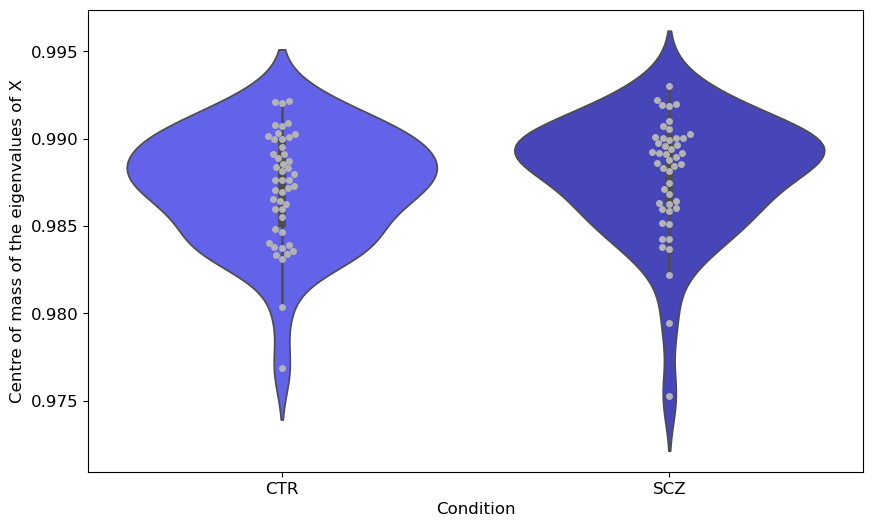

In [25]:
#%% plots

matplotlib.rc('font', size=12) 
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)

cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]]
cols2 = [[0.7,0.7,1],[0.6,0.6,1],[0.5,0.5,1],[0.4,0.4,1]]

X_typ_tmp = dict()
X_typ_tmp['condition'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()
X_typ_tmp['X_typ'] = X_typ.flatten()

X_typ_df = pd.DataFrame(X_typ_tmp)

# real data
# Create the figure
plt.figure(figsize=(10, 6))
ax = sb.violinplot(data=X_typ_df, x='condition', y='X_typ', palette=cols)
sb.swarmplot(data=X_typ_df, x='condition', y='X_typ', color=[0.7,0.7,0.7])
#plt.axis(ymin=0, ymax=8)

plt.xlabel('Condition', fontsize=12)
plt.ylabel('Centre of mass of the eigenvalues of X', fontsize=12)

plt.savefig(os.path.join(res_dir, f'X_typ.eps'), format='eps')


Statistical Test Results:
Mann-Whitney U test statistic: 941.00
p-value: 0.218
NO statistically significant difference between the distributions of the two groups


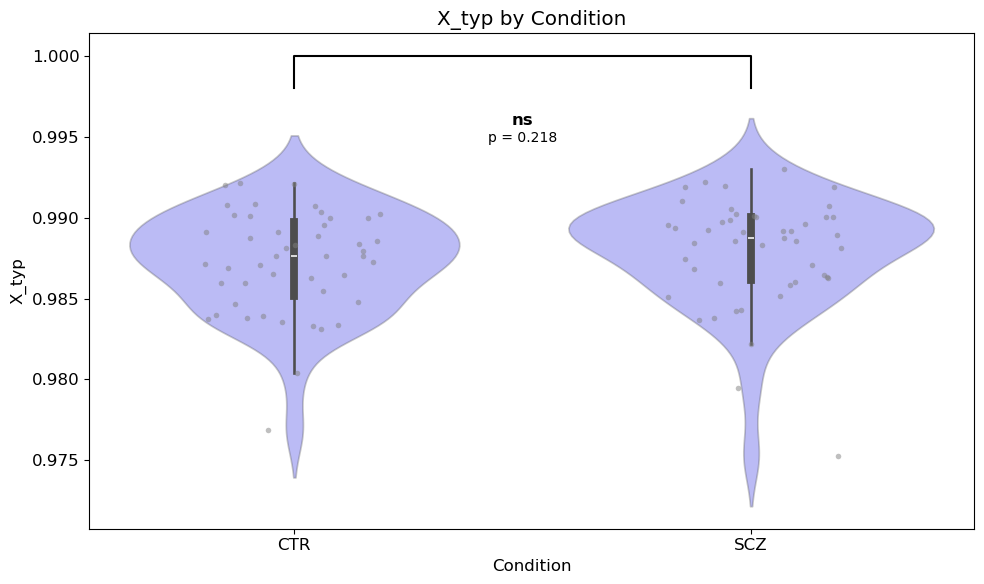

In [26]:
#trial
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Create sample data (replace with your actual data)
data = pd.DataFrame({
    'Condition': ['CTR']*47 + ['SCZ']*47,
    'X_typical': np.concatenate([
        X_typ_df[X_typ_df['condition'] == 'CTR']['X_typ'].tolist(),
        X_typ_df[X_typ_df['condition'] == 'SCZ']['X_typ'].tolist()
    ])
})

# Perform statistical test
ctr_data = data[data['Condition'] == 'CTR']['X_typical']
scz_data = data[data['Condition'] == 'SCZ']['X_typical']

# Perform Mann-Whitney U test (non-parametric test for independent samples)
statistic, p_value = stats.mannwhitneyu(ctr_data, scz_data, alternative='two-sided')

# Create the figure
plt.figure(figsize=(10, 6))

# Create violin plot
sns.violinplot(data=data, 
               x='Condition', 
               y='X_typical',
               color='blue',
               alpha=0.3)

# Add strip plot (individual points)
sns.stripplot(data=data,
             x='Condition',
             y='X_typical',
             color='gray',
             alpha=0.5,
             jitter=0.2,
             size=4)

# Add significance bar
def improved_stat_annotation(p_value):
    # Define significance level markers
    if p_value < 0.001:
        star_string = '***'
    elif p_value < 0.01:
        star_string = '**'
    elif p_value < 0.05:
        star_string = '*'
    else:
        star_string = 'ns'  # Not significant
    
    # Get the highest data value dynamically
    y_max = data['X_typical'].max()
    bar_height = y_max + 0.005  # Adjusted for better placement

    # Plot significance bar
    x1, x2 = 0, 1  # X positions for CTR and SCZ
    plt.plot([x1, x1, x2, x2], 
             [bar_height, bar_height + 0.002, bar_height + 0.002, bar_height],
             'k-', linewidth=1.5)
    
    # Add significance stars
    plt.text((x1 + x2) * 0.5, bar_height - 0.0025, star_string,
             ha='center', va='bottom', fontsize=12, fontweight='bold')

    # Add p-value annotation separately
    plt.text((x1 + x2) * 0.5, bar_height - 0.0035, f'p = {p_value:.3f}',
             ha='center', va='bottom', fontsize=10)

# Add the significance annotation
improved_stat_annotation(p_value)

# Customize the plot
plt.title('X_typ by Condition')
plt.xlabel('Condition')
plt.ylabel('X_typ')
#plt.ylim(0, 9)  # Adjust the upper limit if needed to show the significance bar
#plt.grid(True, alpha=0.3)
plt.tight_layout()

'''
# Adjust layout
plt.show()
'''

plt.savefig(os.path.join(res_dir, 'X_typ_stat_test.jpg'), format='jpg', dpi=300)

# Print statistical test results
print(f'\nStatistical Test Results:')
print(f'Mann-Whitney U test statistic: {statistic:.2f}')
print(f'p-value: {p_value:.3f}')
if p_value <= 0.05:
    print("statistically significant difference between the distributions of the two groups")
else: 
    print("NO statistically significant difference between the distributions of the two groups")

## Robust statistical test: multiple comparison test -> find the brain regions of interest

- STATISTICAL MULTITEST:

bonferroni : one-step correction

sidak : one-step correction

holm-sidak : step down method using Sidak adjustments

holm : step-down method using Bonferroni adjustments

simes-hochberg : step-up method (independent)

hommel : closed method based on Simes tests (non-negative)

fdr_bh : Benjamini/Hochberg (non-negative)

fdr_by : Benjamini/Yekutieli (negative)

fdr_tsbh : two stage fdr correction (non-negative)

fdr_tsbky : two stage fdr correction (non-negative)


- How to choose the appropriate STATISTICAL TEST:

Bonferroni = reduces at the minimum the type I errors (type I = detects a significant difference when none actually exists), this maximize the type II errors (type II = there is some significant difference that gets ignored). It consists in dividing the original p-value threshold alpha by the number of tests. 
IT ENSURES ALMOST 0 TYPE I ERRORS

FDR_BH = better balance between Type I and Type II errors, allows some false positives but controls their proportion. 

Bonferroni eliminates false positives but at the cost of missing real effects.
FDR-BH finds more true effects while allowing a small number of false positives.
FDR-BH better for our case.

If you include the correction it doesn't show any statistical difference. Even if you try with other multitests. 

If we don't include the correction we get 4 regions. There is a high risk of type I errors in this case. 

# Stat significant diff brain connections X

Using a matrix for each partecipant to do the statistical test

In [91]:
from scipy.stats import ttest_ind_from_stats
import statsmodels.stats.multitest as smm

# Initialize lists to store results for each (i, j) brain region pair
p_values_list = []
region_1_list = []
region_2_list = []

# Iterate over each (i, j) pair, considering all entries (not just upper triangle)
for i in range(N):
    for j in range(N):  # Now including the full NxN matrix (not assuming symmetry)
        # Extract data for the current brain region interaction (i, j)
        group_0 = X_indiv[:, 0, i, j]  # Control group
        group_1 = X_indiv[:, 1, i, j]  # Schizophrenic group

        p = stats.mannwhitneyu(group_0, group_1, alternative='two-sided').pvalue

        # Store results
        p_values_list.append(p)
        region_1_list.append(i)
        region_2_list.append(j)

# Convert p-values to numpy array for multiple comparison correction
p_values_array = np.array(p_values_list)

# Apply FDR correction (Benjamini-Hochberg)
_, p_corrected, _, _ = smm.multipletests(p_values_array, alpha=0.05, method='fdr_bh')

# Store results in a DataFrame
results_df = pd.DataFrame({
    "Brain Region 1": region_1_list,
    "Brain Region 2": region_2_list,
    "p-value": p_values_list,
    "corrected p-value": p_corrected
})

# Filter significant brain region pairs based on FDR correction
significant_interactions = results_df[results_df["corrected p-value"] < 0.05]
significant_interactions_nocorr = results_df[results_df["p-value"] < 0.01]

# Print results
print("\nStatistical Analysis Results:\n")
#print(results_df)

# Convert DataFrame to dictionary
results_dict = results_df.to_dict(orient="list")

# Save dictionary as a .npy file
np.save("X_corr.npy", results_dict)

print("\nSignificant Brain Region Pairs (statistically significant interactions after correction):")
#(significant_interactions[["Brain Region 1", "Brain Region 2"]].values.tolist())
print(len(significant_interactions[["Brain Region 1", "Brain Region 2"]].values.tolist()))
print("\nSignificant Brain Region Pairs (statistically significant interactions after NO correction but alpha = 0.01):")
#print(significant_interactions_nocorr[["Brain Region 1", "Brain Region 2"]].values.tolist())
print(len(significant_interactions_nocorr[["Brain Region 1", "Brain Region 2"]].values.tolist()))


Statistical Analysis Results:


Significant Brain Region Pairs (statistically significant interactions after correction):
0

Significant Brain Region Pairs (statistically significant interactions after NO correction but alpha = 0.01):
46


Getting a mean matrix per condition and then running the statistical test

In [28]:
# Compute mean and standard deviation matrices for each condition

# Initialize matrices to store the results
mean_matrices = np.zeros((n_cond, N, N))
std_matrices = np.zeros((n_cond, N, N))

# Iterate over each condition (control and schizophrenia)
for cond in range(n_cond):
    mean_matrices[cond] = np.mean(X_indiv[:, cond, :, :], axis=0)  # Mean over subjects
    std_matrices[cond] = np.std(X_indiv[:, cond, :, :], axis=0, ddof=1)  # Standard deviation over subjects

# Store results in dictionary format for easy access
results = {
    "Mean Matrices": mean_matrices,
    "Standard Deviation Matrices": std_matrices
}

# Save results as numpy arrays for download
mean_filename = "./results/mean_matrices.npy"
std_filename = "./results/std_matrices.npy"
np.save(mean_filename, mean_matrices)
np.save(std_filename, std_matrices)

# Provide file links for download
print(f"\nMean matrices saved to: {mean_filename}")
print(f"Standard deviation matrices saved to: {std_filename}")


Mean matrices saved to: ./results/mean_matrices.npy
Standard deviation matrices saved to: ./results/std_matrices.npy


In [29]:
mean_matrices.shape
np.save(os.path.join(res_dir, f'X_mean.npy'),mean_matrices)

In [30]:
std_matrices.shape
np.save(os.path.join(res_dir, f'X_std.npy'),std_matrices)

In [31]:
X_mean_ctr = mean_matrices[0, :, :]
X_std_ctr = std_matrices[0, :, :]
X_mean_scz = mean_matrices[1, :, :]
X_std_scz = std_matrices[1, :, :]

#print
print(X_mean_scz.shape)
print(X_mean_ctr.shape)
print(X_std_scz.shape)
print(X_std_ctr.shape)

# Save each vector as a separate .npy file
np.save(os.path.join(res_dir, f'X_mean_ctr.npy'),X_mean_ctr)
np.save(os.path.join(res_dir, f'X_mean_scz.npy'),X_mean_scz)
np.save(os.path.join(res_dir, f'X_std_ctr.npy'),X_std_ctr)
np.save(os.path.join(res_dir, f'X_std_scz.npy'),X_std_scz)

(68, 68)
(68, 68)
(68, 68)
(68, 68)


In [32]:
from scipy.stats import ttest_ind_from_stats
import statsmodels.stats.multitest as smm

def welch_t_test_scipy(mean_matrices, std_matrices, n_1, n_2):
    # Extract means and standard deviations
    mean_1, mean_2 = mean_matrices[0], mean_matrices[1]
    std_1, std_2 = std_matrices[0], std_matrices[1]

    # Compute Welch’s t-test for each element using scipy (vectorized)
    t_values, p_values = ttest_ind_from_stats(mean1=mean_1, std1=std_1, nobs1=n_1,
                                              mean2=mean_2, std2=std_2, nobs2=n_2,
                                              equal_var=False)

    # Apply FDR correction
    _, p_values_corrected, _, _ = smm.multipletests(p_values.flatten(), method='fdr_bh')
    p_values_corrected = p_values_corrected.reshape(mean_1.shape)  # Reshape back

    return t_values, p_values, p_values_corrected

# Example usage
n_1 = 47  # Number of samples in group 1
n_2 = 47  # Number of samples in group 2

t_values, p_values, p_values_corrected = welch_t_test_scipy(mean_matrices, std_matrices, n_1, n_2)

# Identify significant elements
significant_elements = p_values_corrected < 0.05
significant_elements_nocorr = p_values < 0.01

# Print the number of significant elements
print(f"Number of significant elements after correction: {np.sum(significant_elements)}")
print(f"Number of significant elements after NO correction: {np.sum(significant_elements_nocorr)}")

# Get indices of significant values (row, col format)
'''
indices = np.argwhere(p_values < 0.01)
for i, j in indices:
    print(f"[{i}, {j}]")
'''

Number of significant elements after correction: 0
Number of significant elements after NO correction: 43


'\nindices = np.argwhere(p_values < 0.01)\nfor i, j in indices:\n    print(f"[{i}, {j}]")\n'

# Connecting Detail Balance Violation, Entropy production and Violation of Fluctuation Dissipation Theorem


# Analyzing X^(-1) = 1 + D^(-1)Q



DQ represents D^(-1)Q

In [33]:
Q_indiv = np.zeros([n_sub,n_cond,N,N])
Q_indiv_mod = np.zeros([n_sub,n_cond,N,N])
Q_antisym = np.zeros([n_sub, n_cond], dtype=bool)
D_indiv = np.zeros([n_sub, n_cond, N, N])
D_inv_indiv = np.zeros([n_sub, n_cond, N, N])
DQ_indiv = np.zeros([n_sub,n_cond,N,N])
DQ_indiv_mod = np.zeros([n_sub,n_cond,N,N])
X_indiv = np.zeros([n_sub,n_cond,N,N])

B_indiv = np.zeros([n_sub,n_cond,N,N])

for i_sub in range(n_sub):
    for i_cond in range(n_cond):

        I = np.eye(N)
        B = np.copy(-J_mod[i_sub,i_cond,:,:].T) # B=-J
        D = np.copy(0.5 * Sigma_mod[i_sub,i_cond,:,:]) # D=1/2 * Sigma
        S = np.copy(FC0_mod[i_sub,i_cond,:,:])
        
        Q = np.dot(B, S) - D
        DQ = np.dot(np.linalg.pinv(D), Q)
        X = np.linalg.pinv(I + DQ)

        B_indiv[i_sub,i_cond,:,:] = B

        D_indiv[i_sub,i_cond,:,:] = D
        D_inv_indiv[i_sub,i_cond,:,:] = np.linalg.inv(D)

        Q_antisym[i_sub, i_cond] = is_antisymmetric(Q)
        Q_indiv[i_sub,i_cond,:,:] = Q        
        Q_indiv_mod[i_sub,i_cond,:,:] = np.absolute(Q)
        DQ_indiv[i_sub,i_cond,:,:] = DQ
        DQ_indiv_mod[i_sub,i_cond,:,:] = np.absolute(DQ)
        X_indiv[i_sub,i_cond,:,:] = X



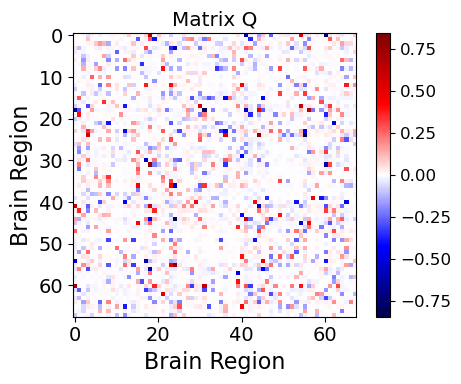

In [34]:
plt.figure(figsize=(5,4))
plt.imshow(Q_indiv[0,1,:,:], cmap='seismic') 
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Matrix Q')
plt.xlabel('Brain Region', fontsize=16)
plt.ylabel('Brain Region', fontsize=16)
plt.tight_layout()

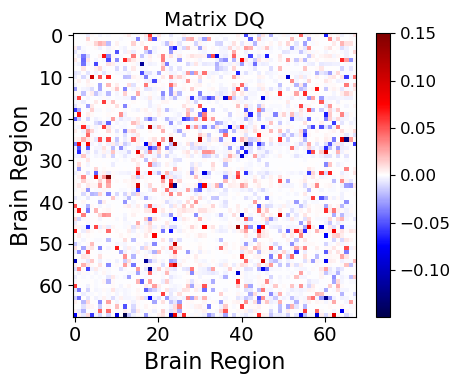

In [35]:
plt.figure(figsize=(5,4))
plt.imshow(DQ_indiv[0,1,:,:], cmap='seismic') 
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Matrix DQ')
plt.xlabel('Brain Region', fontsize=16)
plt.ylabel('Brain Region', fontsize=16)
plt.tight_layout()

## Get the coordinates from the correct ATLAS:

In [36]:
import numpy as np
import pandas as pd

# Path to your .node file
node_file = './Desikan-Killiany68.node'  # or use '/mnt/data/Desikan-Killiany68.node' if in notebook

# Step 1: Read the file and skip the header
with open(node_file, 'r') as f:
    lines = f.readlines()

# Step 2: Parse each line (excluding header)
data_lines = lines[1:]  # skip header, typically 'nodes'

# Step 3: Split lines and extract coordinates + labels
coords = []
labels = []

for line in data_lines:
    parts = line.strip().split()
    if len(parts) >= 5:
        x, y, z = map(float, parts[:3])
        label = parts[-1]
        coords.append([x, y, z])
        labels.append(label)
    else:
        print(f"Warning: malformed line skipped -> {line}")

coords = np.array(coords)  # shape (68, 3)

# Step 4: Wrap into a DataFrame for easy inspection
df_node = pd.DataFrame(coords, columns=['x', 'y', 'z'])
df_node['Label'] = labels

# Step 5: Show first few rows to verify
print(df_node.head())

# Optional: Save to CSV for manual inspection
# df_node.to_csv("parsed_node_file.csv", index=False)


           x          y          z                      Label
0 -54.343785 -44.539029   4.163784                 l.bankssts
1  -5.030493  20.087970  28.999343  l.caudalanteriorcingulate
2 -35.521824  10.809538  44.190969      l.caudalmiddlefrontal
3  -7.126394 -79.633054  18.510034                   l.cuneus
4 -22.998997  -7.877750 -35.210045               l.entorhinal


## Analyzing vectors coming from Q and X

In [37]:
Q_indiv = np.zeros([n_sub,n_cond,N,N])
D_indiv = np.zeros([n_sub, n_cond, N, N])
X_indiv = np.zeros([n_sub,n_cond,N,N])
DQ_indiv = np.zeros([n_sub,n_cond,N,N])
X_indiv_simm = np.zeros([n_sub,n_cond,N,N])
DQ_indiv_simm = np.zeros([n_sub,n_cond,N,N])

V_Qm = np.zeros([n_sub, n_cond, N]) 
V_simm = np.zeros([n_sub, n_cond, N]) 
V_DQ_simm = np.zeros([n_sub, n_cond, N]) 

for i_sub in range(n_sub):
    for i_cond in range(n_cond):

        I = np.eye(N)
        B = np.copy(-J_mod[i_sub,i_cond,:,:].T) # B=-J
        D = np.copy(0.5 * Sigma_mod[i_sub,i_cond,:,:]) # D=1/2 * Sigma
        S = np.copy(FC0_mod[i_sub,i_cond,:,:])
        
        Q = np.dot(B, S) - D
        DQ = np.dot(np.linalg.pinv(D), Q)
        X = np.linalg.pinv(I + DQ)

        # Take modulus of Q:
        Q_mod = np.abs(Q)

        # Take the modulus and symmetrize: 
        DQ_simm =0.5*(np.abs(DQ) + np.abs(DQ).T)
        X_simm =0.5*(np.abs(X) + np.abs(X).T)

        # Compute the corresponding vectors: 
        V = X_simm.sum(axis=1).reshape(-1, 1)
        V_DQ = DQ_simm.sum(axis=1).reshape(-1, 1)
        V_Q = Q_mod.sum(axis=1).reshape(-1, 1)

        V_Qm[i_sub, i_cond, :] = V_Q[:, 0]        
        V_simm[i_sub, i_cond, :] = V[:, 0]
        V_DQ_simm[i_sub, i_cond, :] = V_DQ[:, 0]

        D_indiv[i_sub,i_cond,:,:] = D
        Q_indiv[i_sub,i_cond,:,:] = Q  
        X_indiv[i_sub,i_cond,:,:] = X 
        DQ_indiv[i_sub,i_cond,:,:] = DQ
        X_indiv_simm[i_sub,i_cond,:,:] = X_simm
        DQ_indiv_simm[i_sub,i_cond,:,:] = DQ_simm





# Plot the connections with highest differences between conditions for matrix X and Q :

In [38]:
# Compute means for representation: 

# Assume `data` has shape (n_sub, n_cond, N, N)
mean_X = np.mean(X_indiv, axis=0)  # shape: (n_cond, N, N)
std_X = np.std(X_indiv, axis=0)    # shape: (n_cond, N, N)

mean_diff_X = np.abs(mean_X[0, :, :] - mean_X[1, :, :])
filtered_mdX = np.where(mean_diff_X > 0.015, mean_diff_X , 0.0)

In [39]:
# Compute means for representation: 

# Assume `data` has shape (n_sub, n_cond, N, N)
mean_Q = np.mean(Q_indiv, axis=0)  # shape: (n_cond, N, N)
std_Q = np.std(Q_indiv, axis=0)    # shape: (n_cond, N, N)

mean_diff_Q = np.abs(mean_Q[0, :, :] - mean_Q[1, :, :])
filtered_mdQ = np.where(mean_diff_Q > 0.1, mean_diff_Q , 0.0)

In [40]:
import numpy as np
import pandas as pd
import os
from nilearn import plotting
def symmetrize(conn_matrix): 
    conn_matrix_symm = (conn_matrix + conn_matrix.T) / 2  # make symmetric
    np.fill_diagonal(conn_matrix_symm, 0)
    return conn_matrix_symm

# Plot the connectome
view = plotting.view_connectome(symmetrize(filtered_mdQ), coords, edge_threshold='90%')
view.open_in_browser()

Gtk-Message: 14:05:13.948: Not loading module "atk-bridge": The functionality is provided by GTK natively. Please try to not load it.
[22883, Main Thread] WARNING: GTK+ module /snap/firefox/5947/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.: 'glib warning', file /build/firefox/parts/firefox/build/toolkit/xre/nsSigHandlers.cpp:201

(firefox_firefox:22883): Gtk-WARNING **: 14:05:14.164: GTK+ module /snap/firefox/5947/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.
Gtk-Message: 14:05:14.164: Failed to load module "canberra-gtk-module"
[22883, Main Thread] WARNING: GTK+ module /snap/firefox/5947/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same

In [41]:
# Plot the connectome
view = plotting.view_connectome(symmetrize(filtered_mdX), coords, edge_threshold='90%')
view.open_in_browser()

Gtk-Message: 14:05:15.307: Not loading module "atk-bridge": The functionality is provided by GTK natively. Please try to not load it.
[22982, Main Thread] WARNING: GTK+ module /snap/firefox/5947/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.: 'glib warning', file /build/firefox/parts/firefox/build/toolkit/xre/nsSigHandlers.cpp:201

(firefox_firefox:22982): Gtk-WARNING **: 14:05:15.526: GTK+ module /snap/firefox/5947/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.
Gtk-Message: 14:05:15.526: Failed to load module "canberra-gtk-module"
[22982, Main Thread] WARNING: GTK+ module /snap/firefox/5947/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same

# 3.1 Check behaviour of VQ:

In [42]:
import numpy as np
import scipy.stats as stats
import statsmodels.stats.multitest as smm
import pandas as pd

# Initialize lists to store results
p_values = []

# Iterate over each brain region
for i in range(N):
    # Extract data for the current brain region
    group_0 = V_Qm[:, 0, i]  # Control group
    group_1 = V_Qm[:, 1, i]  # Schizophrenic group

    p = stats.mannwhitneyu(group_0, group_1, alternative='two-sided').pvalue    
    p_values.append(p)

# Convert p-values to numpy array
p_values = np.array(p_values)

# Apply FDR correction (Benjamini-Hochberg)
_, p_corrected, _, _ = smm.multipletests(p_values, alpha=0.05, method='bonferroni')

# Store results in a DataFrame
results_df = pd.DataFrame({
    "Brain Region Index": np.arange(N),
    "p-value": p_values,
    "corrected p-value": p_corrected
})

# Filter significant brain regions
significant_regions = results_df[results_df["corrected p-value"] < 0.05]
significant_uncorrected = results_df[results_df["p-value"] < 0.01]

# Print results
print("\nStatistical Analysis Results:\n")
#print(results_df)

# Extract and print significant brain regions
significant_brain_regions = significant_regions["Brain Region Index"].tolist()
significant_brain_uncorrected = significant_uncorrected["Brain Region Index"].tolist()

print("\nBrain regions of interest (statistically significant differences after Bonferroni correction):")
print(significant_brain_regions)
print("\nBrain regions of interest (statistically significant differences using NO correction, but alpha=0.01):")
print(significant_brain_uncorrected)

np.save(os.path.join(res_dir, f'V_corr.npy'),results_df)



Statistical Analysis Results:


Brain regions of interest (statistically significant differences after Bonferroni correction):
[7, 17]

Brain regions of interest (statistically significant differences using NO correction, but alpha=0.01):
[0, 4, 7, 13, 17, 31, 38, 39, 40, 45, 48, 64]


In [43]:
for i in significant_brain_regions: 
    print(labels[i])

l.inferiortemporal
l.parsorbitalis


/tmp/ipykernel_22283/489406012.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(data=V_component_df, x='Condition', y='V_Qm', inner=None, palette=cols)
/tmp/ipykernel_22283/489406012.py:20: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sb.violinplot(data=V_component_df, x='Condition', y='V_Qm', inner=None, palette=cols)


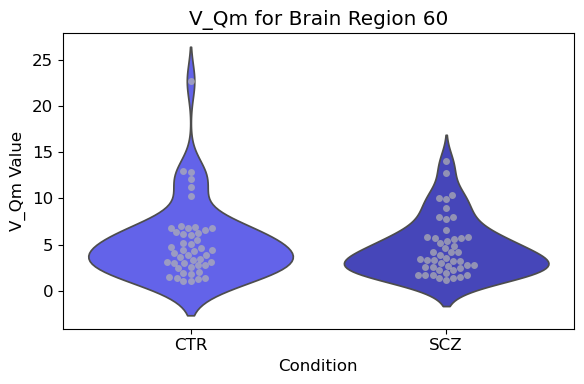

In [44]:
#Choose the brain region:
i = 60

cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]]
cols2 = [[0.7,0.7,1],[0.6,0.6,1],[0.5,0.5,1],[0.4,0.4,1]]

plt.figure(figsize=(6, 4))

# Extract data for the specific component across conditions and subjects
V_component = V_Qm[:, :, i]  # Shape (n_sub, n_cond)

# Create DataFrame for violin plot
V_component_tmp = {
    'Condition': np.tile(conds, n_sub),
    'V_Qm': V_component.flatten()
}

V_component_df = pd.DataFrame(V_component_tmp)
# Violin plot
sb.violinplot(data=V_component_df, x='Condition', y='V_Qm', inner=None, palette=cols)
sb.swarmplot(data=V_component_df, x='Condition', y='V_Qm', color=[0.7,0.7,0.7], alpha=0.7)
# Formatting the plot
plt.xlabel("Condition")
plt.ylabel("V_Qm Value")
plt.title(f"V_Qm for Brain Region {i}")
#plt.grid(True, linestyle='--', alpha=0.6)
# Show the plot
plt.tight_layout()
plt.show()

In [45]:
# Compute mean and standard deviation over n_sub
V_Q_mean = np.mean(V_Qm, axis=0)  # Shape [n_cond, N]
V_Q_std = np.std(V_Qm, axis=0)  # Shape [n_cond, N]

# Save each vector as a separate .npy file
np.save(os.path.join(res_dir, f'V_Q_mean.npy'),V_Q_mean)
np.save(os.path.join(res_dir, f'V_Q_std.npy'),V_Q_std)

In [46]:
V_Q_mean.shape

(2, 68)

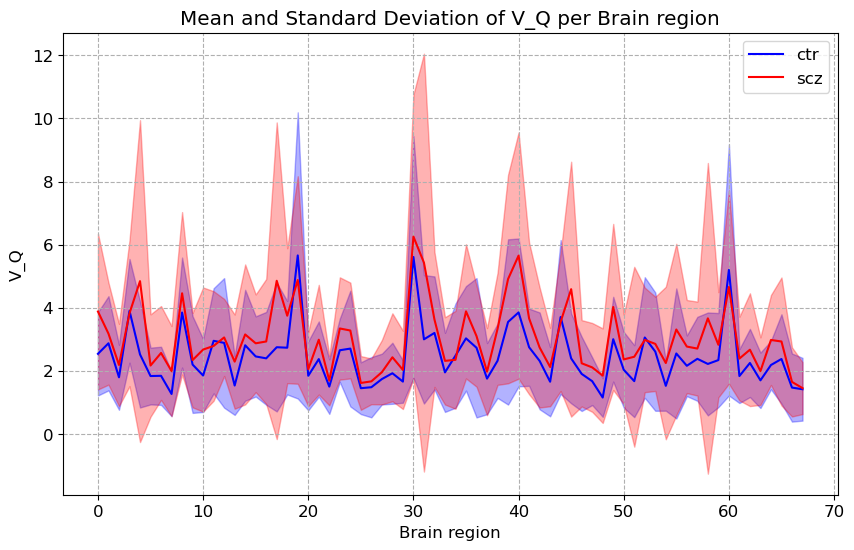

In [47]:
# X-axis values
x = np.arange(N)

# color palette
cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot for control group
plt.plot(x, V_Q_mean[0, :], label="ctr", color="blue")
plt.fill_between(x, V_Q_mean[0, :] - V_Q_std[0, :], V_Q_mean[0, :] + V_Q_std[0, :], color="blue", alpha=0.3)

# Plot for schizophrenia group
plt.plot(x, V_Q_mean[1, :], label="scz", color="red")
plt.fill_between(x, V_Q_mean[1, :] - V_Q_std[1, :], V_Q_mean[1, :] + V_Q_std[1, :], color="red", alpha=0.3)

# Labels and legend
plt.xlabel("Brain region")
plt.ylabel("V_Q")
plt.title("Mean and Standard Deviation of V_Q per Brain region")
plt.legend()
plt.grid(True, linestyle='--')

# Show the plot
plt.savefig(os.path.join(res_dir, f'V_mean_std_Q.jpg'), format='jpg', dpi=300)

# Ranking vector coming from |Q| depending on the degree of irreversibility

In [48]:
V_Q_mean_diff = np.abs(V_Q_mean[0, :] - V_Q_mean[1, :])
print(V_Q_mean_diff.shape)
print(V_Q_mean_diff)

(68,)
[1.33983847 0.3054776  0.39079853 0.07432479 2.32272786 0.33323348
 0.72395396 0.72463873 0.61070153 0.1420236  0.82261474 0.16256799
 0.17267327 0.75776258 0.34264923 0.41649192 0.53450523 2.10568434
 1.01403427 0.77853573 0.2087655  0.61422593 0.1908791  0.68992171
 0.57273088 0.16616719 0.18590883 0.21722539 0.50654276 0.37078299
 0.64485742 2.43025528 0.42515727 0.36444499 0.13193771 0.85605779
 0.3688505  0.22082388 1.01112691 1.35972884 1.79997578 0.91314076
 0.42367952 0.4662417  0.1528705  2.19405602 0.33649678 0.43699306
 0.69358211 1.02150952 0.32793394 0.77342945 0.07654065 0.24618706
 0.72272893 0.75958913 0.60926193 0.32467135 1.44465265 0.4851297
 0.54056655 0.55362915 0.42087905 0.2914764  0.79367729 0.55391498
 0.17963963 0.03561369]


In [49]:
import numpy as np
import pandas as pd

# Load the .node file
with open("Desikan-Killiany68.node", 'r') as f:
    lines = f.readlines()

# Extract region names (last column of each non-comment line)
region_data = [line.strip().split() for line in lines if not line.startswith('#')]
region_names = [fields[-1] for fields in region_data]

print(region_names)

['l.bankssts', 'l.caudalanteriorcingulate', 'l.caudalmiddlefrontal', 'l.cuneus', 'l.entorhinal', 'l.fusiform', 'l.inferiorparietal', 'l.inferiortemporal', 'l.isthmuscingulate', 'l.lateraloccipital', 'l.lateralorbitofrontal', 'l.lingual', 'l.medialorbitofrontal', 'l.middletemporal', 'l.parahippocampal', 'l.paracentral', 'l.parsopercularis', 'l.parsorbitalis', 'l.parstriangularis', 'l.pericalcarine', 'l.postcentral', 'l.posteriorcingulate', 'l.precentral', 'l.precuneus', 'l.rostralanteriorcingulate', 'l.rostralmiddlefrontal', 'l.superiorfrontal', 'l.superiorparietal', 'l.superiortemporal', 'l.supramarginal', 'l.frontalpole', 'l.temporalpole', 'l.transversetemporal', 'l.insula', 'r.bankssts', 'r.caudalanteriorcingulate', 'r.caudalmiddlefrontal', 'r.cuneus', 'r.entorhinal', 'r.fusiform', 'r.inferiorparietal', 'r.inferiortemporal', 'r.isthmuscingulate', 'r.lateraloccipital', 'r.lateralorbitofrontal', 'r.lingual', 'r.medialorbitofrontal', 'r.middletemporal', 'r.parahippocampal', 'r.paracentr

In [50]:
# Create DataFrame and sort by value
df_VQ = pd.DataFrame({
    'Region': region_names,
    'Value': V_Q_mean_diff
})
df_VQ_sorted = df_VQ.sort_values(by='Value', ascending=False).reset_index(drop=True)

# Display or use df_sorted as needed
print(df_VQ_sorted)


                Region     Value
0       l.temporalpole  2.430255
1         l.entorhinal  2.322728
2            r.lingual  2.194056
3      l.parsorbitalis  2.105684
4   r.inferiorparietal  1.799976
..                 ...       ...
63  l.lateraloccipital  0.142024
64          r.bankssts  0.131938
65  r.parstriangularis  0.076541
66            l.cuneus  0.074325
67            r.insula  0.035614

[68 rows x 2 columns]


Visualization: 

In [51]:
from enigmatoolbox.utils.parcellation import parcel_to_surface

from enigmatoolbox.plotting import plot_cortical

from enigmatoolbox.datasets import load_fsa5


# Map parcellated data to the surface

CT_d_fsa5 = parcel_to_surface(V_Q_mean_diff, 'aparc_fsa5')

# Project the results on the surface brain

plot_cortical(array_name=CT_d_fsa5, surface_name="fsa5", size=(800, 400),

              cmap='RdBu_r', color_bar=True, color_range=(-0.5, 0.5))


2025-04-11 14:05:20.566 (   2.854s) [    721FF231F440] vtkPythonAlgorithm.cxx:97     ERR| vtkPythonAlgorithm (0x5ba61c38aec0): Failure when calling method: "ProcessRequest":


TypeError: SetCells argument 2: 

2025-04-11 14:05:21.032 (   3.320s) [    721FF231F440]       vtkExecutive.cxx:729    ERR| vtkCompositeDataPipeline (0x5ba61952fc40): Algorithm vtkPythonAlgorithm (0x5ba61c38aec0) returned failure for request: vtkInformation (0x5ba61c348d70)
  Debug: Off
  Modified Time: 213
  Reference Count: 2
  Registered Events: (none)
  Request: REQUEST_DATA
  FROM_OUTPUT_PORT: 0
  ALGORITHM_AFTER_FORWARD: 1
  FORWARD_DIRECTION: 0




AttributeError: type object 'PointSet' has no attribute '__vtkname__'

# 4. Analyze the vectors coming from |X|

/tmp/ipykernel_22283/3286340754.py:20: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sb.violinplot(data=V_component_df, x='Condition', y='V_simm', inner=None, palette=cols)


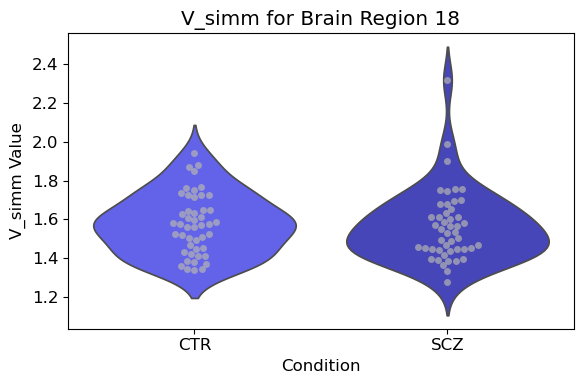

In [53]:
#Choose the brain region:
i = 18

cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]]
cols2 = [[0.7,0.7,1],[0.6,0.6,1],[0.5,0.5,1],[0.4,0.4,1]]

plt.figure(figsize=(6, 4))

# Extract data for the specific component across conditions and subjects
V_component = V_simm[:, :, i]  # Shape (n_sub, n_cond)

# Create DataFrame for violin plot
V_component_tmp = {
    'Condition': np.tile(conds, n_sub),
    'V_simm': V_component.flatten()
}

V_component_df = pd.DataFrame(V_component_tmp)
# Violin plot
sb.violinplot(data=V_component_df, x='Condition', y='V_simm', inner=None, palette=cols)
sb.swarmplot(data=V_component_df, x='Condition', y='V_simm', color=[0.7,0.7,0.7], alpha=0.7)
# Formatting the plot
plt.xlabel("Condition")
plt.ylabel("V_simm Value")
plt.title(f"V_simm for Brain Region {i}")
#plt.grid(True, linestyle='--', alpha=0.6)
# Show the plot
plt.tight_layout()
plt.show()

In [54]:
# Compute mean and standard deviation over n_sub
V_mean_simm = np.mean(V_simm, axis=0)  # Shape [n_cond, N]
V_std_simm = np.std(V_simm, axis=0)  # Shape [n_cond, N]

V_mean_ctr_simm = V_mean_simm[0, :]
V_mean_scz_simm = V_mean_simm[1, :]
V_std_ctr_simm = V_std_simm[0, :]
V_std_scz_simm = V_std_simm[1, :]

# Save each vector as a separate .npy file
np.save(os.path.join(res_dir, f'V_mean_simm.npy'),V_mean_simm)
np.save(os.path.join(res_dir, f'V_std_simm.npy'),V_std_simm)

In [55]:
print(V_mean_simm.shape)
print(V_std_simm.shape)

(2, 68)
(2, 68)


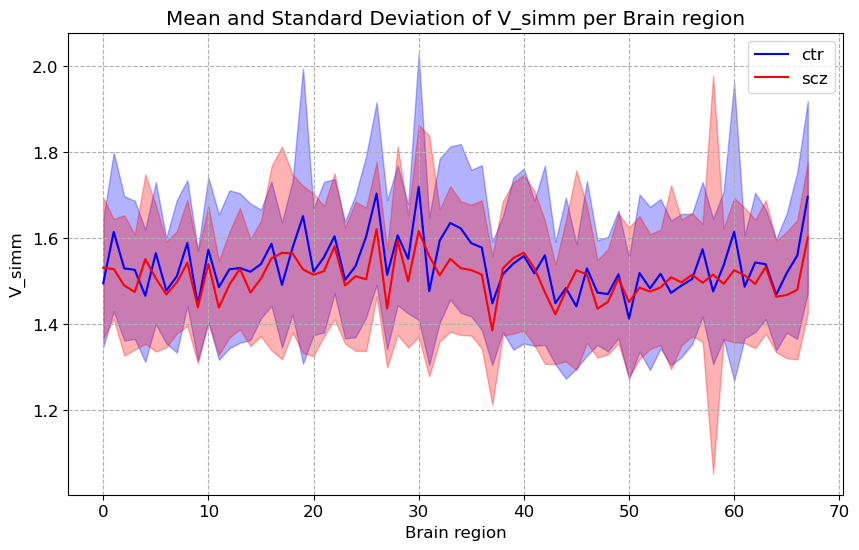

In [56]:
# X-axis values
x = np.arange(N)

# color palette
cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot for control group
plt.plot(x, V_mean_simm[0, :], label="ctr", color="blue")
plt.fill_between(x, V_mean_simm[0, :] - V_std_simm[0, :], V_mean_simm[0, :] + V_std_simm[0, :], color="blue", alpha=0.3)

# Plot for schizophrenia group
plt.plot(x, V_mean_simm[1, :], label="scz", color="red")
plt.fill_between(x, V_mean_simm[1, :] - V_std_simm[1, :], V_mean_simm[1, :] + V_std_simm[1, :], color="red", alpha=0.3)

# Labels and legend
plt.xlabel("Brain region")
plt.ylabel("V_simm")
plt.title("Mean and Standard Deviation of V_simm per Brain region")
plt.legend()
plt.grid(True, linestyle='--')

# Show the plot
plt.savefig(os.path.join(res_dir, f'V_mean_std_simm.jpg'), format='jpg', dpi=300)

## Ranking vector coming from |X| depending on the degree of irreversibility

In [57]:
import numpy as np
import pandas as pd

# Load the .node file
with open("Desikan-Killiany68.node", 'r') as f:
    lines = f.readlines()

# Extract region names (last column of each non-comment line)
region_data = [line.strip().split() for line in lines if not line.startswith('#')]
region_names = [fields[-1] for fields in region_data]

print(region_names)

#Difference vector
V_mean_simm_diff = np.abs(V_mean_simm[0, :] - V_mean_simm[1, :])

# Create DataFrame and sort by value
df_VX = pd.DataFrame({
    'Region': region_names,
    'Value': V_mean_simm_diff 
})
df_VX_sorted = df_VX.sort_values(by='Value', ascending=False).reset_index(drop=True)

# Display or use df_sorted as needed
print(df_VX_sorted)

['l.bankssts', 'l.caudalanteriorcingulate', 'l.caudalmiddlefrontal', 'l.cuneus', 'l.entorhinal', 'l.fusiform', 'l.inferiorparietal', 'l.inferiortemporal', 'l.isthmuscingulate', 'l.lateraloccipital', 'l.lateralorbitofrontal', 'l.lingual', 'l.medialorbitofrontal', 'l.middletemporal', 'l.parahippocampal', 'l.paracentral', 'l.parsopercularis', 'l.parsorbitalis', 'l.parstriangularis', 'l.pericalcarine', 'l.postcentral', 'l.posteriorcingulate', 'l.precentral', 'l.precuneus', 'l.rostralanteriorcingulate', 'l.rostralmiddlefrontal', 'l.superiorfrontal', 'l.superiorparietal', 'l.superiortemporal', 'l.supramarginal', 'l.frontalpole', 'l.temporalpole', 'l.transversetemporal', 'l.insula', 'r.bankssts', 'r.caudalanteriorcingulate', 'r.caudalmiddlefrontal', 'r.cuneus', 'r.entorhinal', 'r.fusiform', 'r.inferiorparietal', 'r.inferiortemporal', 'r.isthmuscingulate', 'r.lateraloccipital', 'r.lateralorbitofrontal', 'r.lingual', 'r.medialorbitofrontal', 'r.middletemporal', 'r.parahippocampal', 'r.paracentr

In [58]:
import numpy as np
import scipy.stats as stats
import statsmodels.stats.multitest as smm
import pandas as pd

# Initialize lists to store results
p_values = []

# Iterate over each brain region
for i in range(N):
    # Extract data for the current brain region
    group_0 = V_simm[:, 0, i]  # Control group
    group_1 = V_simm[:, 1, i]  # Schizophrenic group

    p = stats.mannwhitneyu(group_0, group_1, alternative='two-sided').pvalue    
    p_values.append(p)

# Convert p-values to numpy array
p_values = np.array(p_values)

# Apply FDR correction (Benjamini-Hochberg)
_, p_corrected, _, _ = smm.multipletests(p_values, alpha=0.05, method='fdr_bh')

# Store results in a DataFrame
results_df = pd.DataFrame({
    "Brain Region Index": np.arange(N),
    "p-value": p_values,
    "corrected p-value": p_corrected
})

# Filter significant brain regions
significant_regions = results_df[results_df["corrected p-value"] < 0.05]
significant_uncorrected = results_df[results_df["p-value"] < 0.01]

# Print results
print("\nStatistical Analysis Results:\n")
#print(results_df)

# Extract and print significant brain regions
significant_brain_regions = significant_regions["Brain Region Index"].tolist()
significant_brain_uncorrected = significant_uncorrected["Brain Region Index"].tolist()

print("\nBrain regions of interest (statistically significant differences after FDR correction):")
print(significant_brain_regions)
print("\nBrain regions of interest (statistically significant differences using NO correction, but alpha=0.01):")
print(significant_brain_uncorrected)

np.save(os.path.join(res_dir, f'V_corr_simm.npy'),results_df)



Statistical Analysis Results:


Brain regions of interest (statistically significant differences after FDR correction):
[]

Brain regions of interest (statistically significant differences using NO correction, but alpha=0.01):
[]


# 5. Do the same analysis for vectors coming from |DQ|:

/tmp/ipykernel_22283/2696054120.py:20: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sb.violinplot(data=V_component_df, x='Condition', y='V_DQ_simm', inner=None, palette=cols)


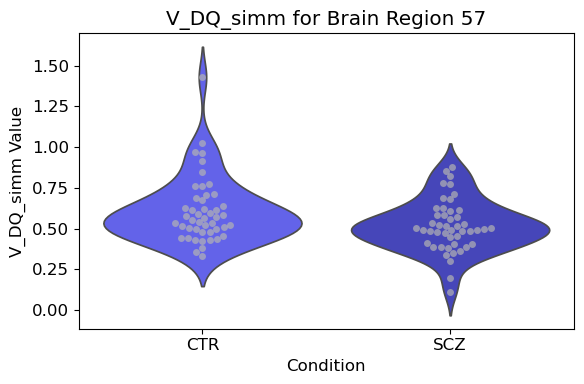

In [59]:
#Choose the brain region:
i = 57

cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]]
cols2 = [[0.7,0.7,1],[0.6,0.6,1],[0.5,0.5,1],[0.4,0.4,1]]

plt.figure(figsize=(6, 4))

# Extract data for the specific component across conditions and subjects
V_component = V_DQ_simm[:, :, i]  # Shape (n_sub, n_cond)

# Create DataFrame for violin plot
V_component_tmp = {
    'Condition': np.tile(conds, n_sub),
    'V_DQ_simm': V_component.flatten()
}

V_component_df = pd.DataFrame(V_component_tmp)
# Violin plot
sb.violinplot(data=V_component_df, x='Condition', y='V_DQ_simm', inner=None, palette=cols)
sb.swarmplot(data=V_component_df, x='Condition', y='V_DQ_simm', color=[0.7,0.7,0.7], alpha=0.7)
# Formatting the plot
plt.xlabel("Condition")
plt.ylabel("V_DQ_simm Value")
plt.title(f"V_DQ_simm for Brain Region {i}")
#plt.grid(True, linestyle='--', alpha=0.6)
# Show the plot
plt.tight_layout()
plt.show()

In [60]:
# Compute mean and standard deviation over n_sub
V_mean_simm_DQ = np.mean(V_DQ_simm, axis=0)  # Shape [n_cond, N]
V_std_simm_DQ = np.std(V_DQ_simm, axis=0)  # Shape [n_cond, N]

V_mean_ctr_simm_DQ = V_mean_simm_DQ[0, :]
V_mean_scz_simm_DQ = V_mean_simm_DQ[1, :]
V_std_ctr_simm_DQ = V_std_simm_DQ[0, :]
V_std_scz_simm_DQ = V_std_simm_DQ[1, :]

# Save each vector as a separate .npy file
np.save(os.path.join(res_dir, f'V_mean_simm_DQ.npy'),V_mean_simm_DQ)
np.save(os.path.join(res_dir, f'V_std_simm_DQ.npy'),V_std_simm_DQ)

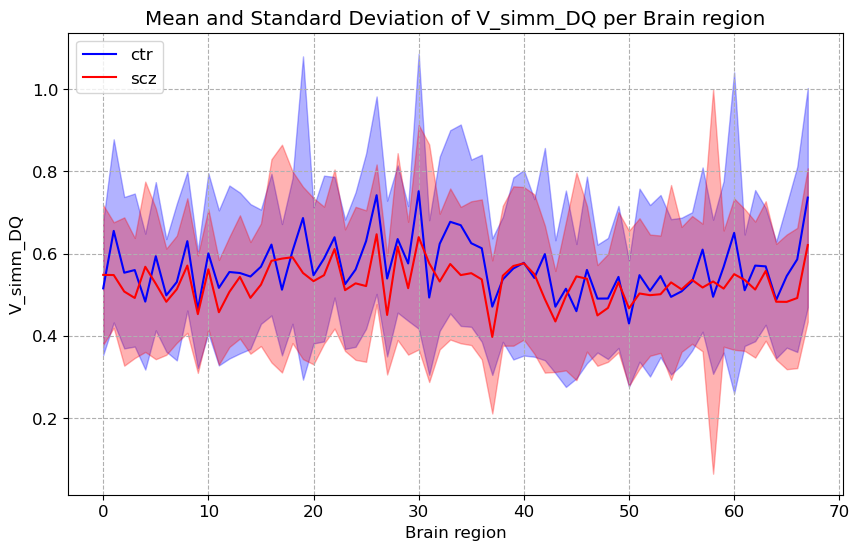

In [61]:
# X-axis values
x = np.arange(N)

# color palette
cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot for control group
plt.plot(x, V_mean_simm_DQ[0, :], label="ctr", color="blue")
plt.fill_between(x, V_mean_simm_DQ[0, :] - V_std_simm_DQ[0, :], V_mean_simm_DQ[0, :] + V_std_simm_DQ[0, :], color="blue", alpha=0.3)

# Plot for schizophrenia group
plt.plot(x, V_mean_simm_DQ[1, :], label="scz", color="red")
plt.fill_between(x, V_mean_simm_DQ[1, :] - V_std_simm_DQ[1, :], V_mean_simm_DQ[1, :] + V_std_simm_DQ[1, :], color="red", alpha=0.3)

# Labels and legend
plt.xlabel("Brain region")
plt.ylabel("V_simm_DQ")
plt.title("Mean and Standard Deviation of V_simm_DQ per Brain region")
plt.legend()
plt.grid(True, linestyle='--')

# Show the plot
plt.savefig(os.path.join(res_dir, f'V_mean_std_simm_DQ.jpg'), format='jpg', dpi=300)

In [62]:
import numpy as np
import scipy.stats as stats
import statsmodels.stats.multitest as smm
import pandas as pd

# Initialize lists to store results
p_values = []

# Iterate over each brain region
for i in range(N):
    # Extract data for the current brain region
    group_0 = V_DQ_simm[:, 0, i]  # Control group
    group_1 = V_DQ_simm[:, 1, i]  # Schizophrenic group

    p = stats.mannwhitneyu(group_0, group_1, alternative='two-sided').pvalue    
    p_values.append(p)

# Convert p-values to numpy array
p_values = np.array(p_values)

# Apply FDR correction (Benjamini-Hochberg)
_, p_corrected, _, _ = smm.multipletests(p_values, alpha=0.05, method='fdr_bh')

# Store results in a DataFrame
results_df = pd.DataFrame({
    "Brain Region Index": np.arange(N),
    "p-value": p_values,
    "corrected p-value": p_corrected
})

# Filter significant brain regions
significant_regions = results_df[results_df["corrected p-value"] < 0.05]
significant_uncorrected = results_df[results_df["p-value"] < 0.01]

# Print results
print("\nStatistical Analysis Results:\n")
#print(results_df)

# Extract and print significant brain regions
significant_brain_regions = significant_regions["Brain Region Index"].tolist()
significant_brain_uncorrected = significant_uncorrected["Brain Region Index"].tolist()

print("\nBrain regions of interest (statistically significant differences after FDR correction):")
print(significant_brain_regions)
print("\nBrain regions of interest (statistically significant differences using NO correction, but alpha=0.01):")
print(significant_brain_uncorrected)

np.save(os.path.join(res_dir, f'V_corr_simm.npy'),results_df)



Statistical Analysis Results:


Brain regions of interest (statistically significant differences after FDR correction):
[]

Brain regions of interest (statistically significant differences using NO correction, but alpha=0.01):
[]


# Linear Response Theory

By changing i_cond and i_sub you get the response of the patient that you want

max time and time step:  TT= 30 and dt=0.1

Latency = how much time it gets to reach the maximum

Area Under the Curve 

latency: [1.1 4.2 2.6 2.4 2.6 2.9 1.8 2.9 1.1 3.8 2.2 2.7 2.3 2.2 2.4 5.  3.6 2.4
 3.2 2.8 4.7 4.7 5.  1.  3.1 4.2 3.7 4.  3.6 2.7 2.9 3.5 3.9 4.2 4.7 2.5
 3.3 3.8 2.5 3.6 1.4 1.1 3.8 2.3 2.5 2.5 4.2 0.  2.1 1.  4.7 4.4 3.8 2.3
 1.  3.2 4.8 3.4 3.6 3.9 2.7 4.4 2.2 4.3 1.  2.7 3.8 4.1], auc: [0.01640157 0.00178461 0.0035986  0.00657114 0.00112088 0.00167383
 0.00551269 0.00228458 0.02233525 0.00135591 0.0018657  0.00428398
 0.00476292 0.00656156 0.00222518 0.00083761 0.00239648 0.01049805
 0.0037385  0.00655267 0.00062243 0.0010247  0.00035894 0.01863887
 0.00364758 0.00101531 0.00108947 0.00173034 0.00185603 0.00455697
 0.00383578 0.00162467 0.00217791 0.00132499 0.00041238 0.0033798
 0.00067747 0.00071041 0.00304521 0.0014349  0.00819362 0.00795317
 0.00170815 0.00268836 0.00400195 0.0011508  0.00039529 0.08936583
 0.00125757 0.0186042  0.00057276 0.00050968 0.00152837 0.00139744
 0.00423331 0.00067165 0.00125612 0.00111825 0.00083814 0.00216567
 0.00412225 0.0013819  0.00185281 0.000

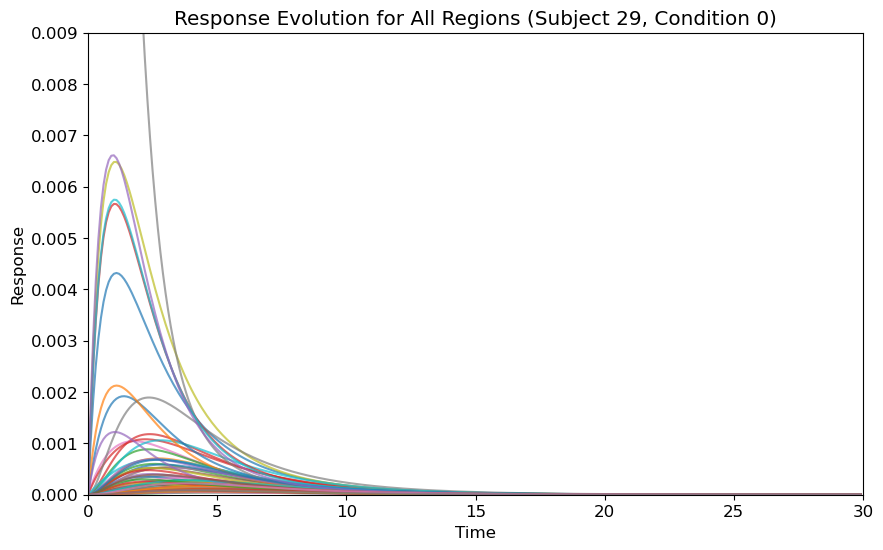

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.integrate import simpson

# ParametersV_indiv, axis=0) 
i_cond = 0  # Choose in [0,1]
i_sub = 29   # Choose in [0, 47]
TT = 30      # Maximum time
dt = 0.1    # Smaller time step for higher resolution
time_points = np.arange(0, TT, dt)  # High-resolution time grid
N = 68

# Initialize response function
p = np.zeros(N)
i_reg = 47  # Example region, but we compute for all
p[i_reg] = 0.1
res = np.zeros((len(time_points), N))

# Matrix B
B = np.copy(-J_mod[i_sub, i_cond, :, :].T)

# Compute the response function over finer time resolution
for i, t in enumerate(time_points):
    res[i, :] = np.matmul(expm(-B * t), p)

# Compute latency and AUC for each region
latency = time_points[np.argmax(res, axis=0)]  # Convert index to actual time
auc = simpson(res, dx=dt, axis=0)  # Adjust dx to match new time step

# Print results
print(f'latency: {latency}, auc: {auc}')

# Plot results for all regions
plt.figure(figsize=(10, 6))
for region in range(N):
    plt.plot(time_points, res[:, region], alpha=0.7, label=f'Region {region}')

plt.ylim([0, 0.009])  # Adjust y-axis for better visualization
plt.xlim([0, TT])
plt.xlabel("Time")
plt.ylabel("Response")
plt.title(f"Response Evolution for All Regions (Subject {i_sub}, Condition {i_cond})")
plt.show()


In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.integrate import simpson

# Parameters
TT = 30      # Maximum time
dt = 0.1     # Smaller time step for higher resolution
time_points = np.arange(0, TT, dt)  # High-resolution time grid
N = 68
num_time_steps = len(time_points)

# Initialize results array
res = np.zeros((n_sub, n_cond, N, num_time_steps, N))

# Loop over subjects and conditions
for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        B = -J_mod[i_sub, i_cond, :, :].T  # Precompute B matrix once
        expm_B_t = np.array([expm(-B * t) for t in time_points])  # Compute all exponentials at once
        
        for i_reg in range(N):
            p = np.zeros(N)
            p[i_reg] = 0.1  # Initial condition at index i
            res[i_sub, i_cond, i_reg, :, :] = np.matmul(expm_B_t, p)  # Correct matrix-vector multiplication

# Compute latency and AUC for each region
latency = time_points[np.argmax(res, axis=3)]  # Convert index to actual time
auc = simpson(res, dx=dt, axis=3)  # Adjust dx to match new time step

# Print results
print(f'latency: {latency.shape}, auc: {auc.shape}')

latency: (47, 2, 68, 68), auc: (47, 2, 68, 68)


Latency (i_sub, i_cond, perturbed region, response region)

AUC (i_sub, i_cond, perturbed region, response region)

how the code was sped up: 

1. precompute exp(-B*t) before looping. 
2. efficient matrix-vector multiplication: np.matmul(expm_B_t,p) all time ponts in one go
3. use vectorized NumPy Operations for Latency and AUC

In [65]:
# Assuming your matrices`have shape (47, 2, 68, 68)
# Compute the mean over the last two dimensions (68 x 68 matrix)
mean_latency = np.mean(latency, axis=(2, 3))
mean_auc = np.mean(auc, axis=(2, 3))
std_latency = np.std(latency, axis=(2, 3))
std_auc = np.std(auc, axis=(2, 3))

# `mean_matrix` will now be a (47, 2) array
print(mean_latency.shape)  # Output: (47, 2)
print(mean_auc.shape)  # Output: (47, 2)
print(std_latency.shape)  # Output: (47, 2)
print(std_auc.shape)  # Output: (47, 2)

(47, 2)
(47, 2)
(47, 2)
(47, 2)


/tmp/ipykernel_22283/3977308645.py:17: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sb.violinplot(data=mean_latency_df, x='Condition', y='Mean Latency', inner=None, palette=cols)


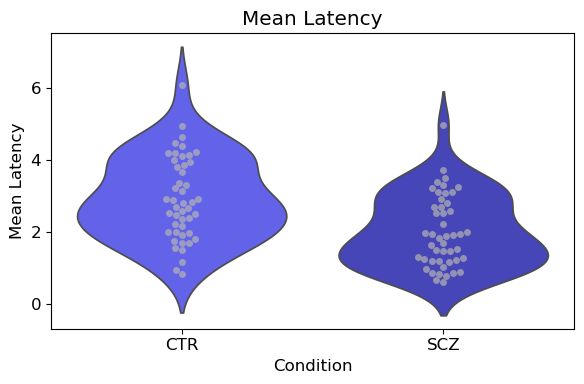

In [66]:

cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]]
cols2 = [[0.7,0.7,1],[0.6,0.6,1],[0.5,0.5,1],[0.4,0.4,1]]

plt.figure(figsize=(6, 4))

# Extract data for the specific component across conditions and subjects
# mean_latency shape (n_sub, n_cond)

# Create DataFrame for violin plot
mean_latency_tmp = {
    'Condition': np.tile(conds, n_sub),
    'Mean Latency': mean_latency.flatten()
}

mean_latency_df = pd.DataFrame(mean_latency_tmp)
# Violin plot
sb.violinplot(data=mean_latency_df, x='Condition', y='Mean Latency', inner=None, palette=cols)
sb.swarmplot(data=mean_latency_df, x='Condition', y='Mean Latency', color=[0.7,0.7,0.7], alpha=0.7)
# Formatting the plot
plt.xlabel("Condition")
plt.ylabel("Mean Latency")
plt.title(f"Mean Latency")
#plt.grid(True, linestyle='--', alpha=0.6)
# Show the plot
plt.tight_layout()

plt.savefig(os.path.join(res_dir, 'Mean_latency.jpg'), format='jpg', dpi=300)

Use the Mann-Whitney test to compare the means, BUT it is NOT appropriate because here we also have a standard deviation for each point, we need to take that into account!

Using the Weighted Least Squares statistical test to take into account the variances

In [67]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Step 1: Flatten the mean and std arrays
mean_flat = mean_latency.flatten()
std_flat = std_latency.flatten()
var_flat = std_flat ** 2

# Step 2: Create group labels: 0 for CTR, 1 for SCZ
condition = np.array([0]*47 + [1]*47)

# Step 3: Build design matrix (intercept + condition dummy)
X = sm.add_constant(condition)  # adds column of 1s for intercept

# Step 4: Fit weighted least squares model
wls_model = sm.WLS(mean_flat, X, weights=1/var_flat)
results = wls_model.fit()

# Step 5: Print summary and interpret
print(results.summary())

# Extract condition effect and p-value
beta = results.params[1]
p_value = results.pvalues[1]

print(f"\nEstimated difference in mean latency (SCZ - CTR): {beta:.3f}")
print(f"p-value for group difference: {p_value:.4f}")
if p_value < 0.05:
    print("✅ Statistically significant difference between groups.")
else:
    print("❌ No statistically significant difference between groups.")


                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.016
Model:                            WLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.501
Date:                Fri, 11 Apr 2025   Prob (F-statistic):              0.224
Time:                        14:07:00   Log-Likelihood:                -141.62
No. Observations:                  94   AIC:                             287.2
Df Residuals:                      92   BIC:                             292.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2826      0.109     11.754      0.0

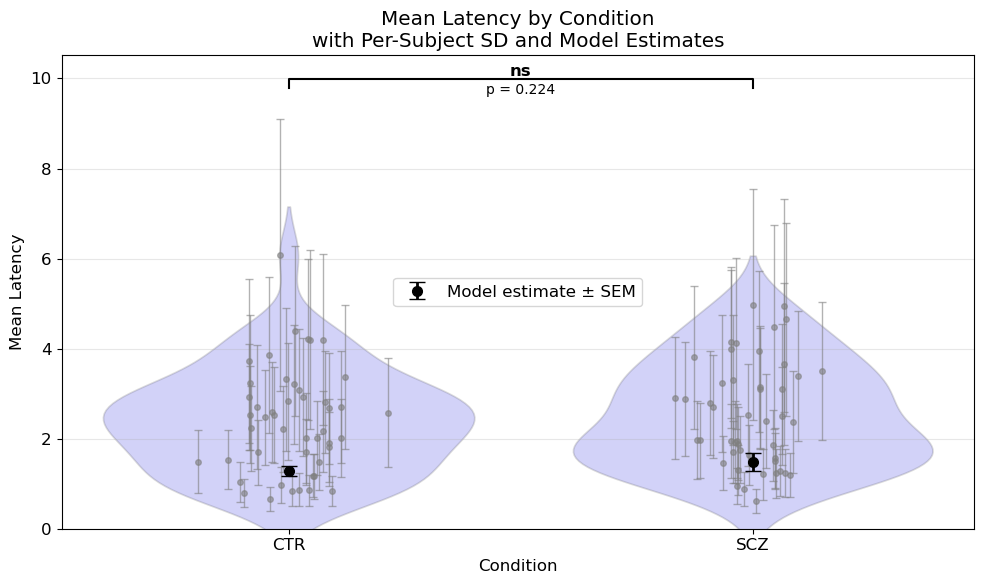

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Prepare flattened data
mean_flat = mean_latency.flatten()
std_flat = std_latency.flatten()
group_labels = np.array(['CTR']*47 + ['SCZ']*47)

# Create DataFrame for plotting
data = pd.DataFrame({
    'Condition': group_labels,
    'Mean_Latency': mean_flat,
    'Std_Latency': std_flat
})

# Calculate model-estimated means and SEMs from WLS
intercept = results.params[0]         # Mean for CTR
diff = results.params[1]              # SCZ - CTR
scz_mean = intercept + diff
stderr_ctr = results.bse[0]
stderr_diff = results.bse[1]
stderr_scz = np.sqrt(stderr_ctr**2 + stderr_diff**2)

# Violin plot (distribution shape only)
plt.figure(figsize=(10, 6))
sns.violinplot(data=data, x='Condition', y='Mean_Latency',
               inner=None, color='blue', alpha=0.2)

# Jittered individual data points with SD error bars
rng = np.random.default_rng(42)
jitter_strength = 0.1
x_positions = data['Condition'].map({'CTR': 0, 'SCZ': 1}).values
x_jittered = x_positions + rng.normal(0, jitter_strength, size=len(x_positions))

plt.errorbar(x=x_jittered,
             y=data['Mean_Latency'],
             yerr=data['Std_Latency'],
             fmt='o',
             ecolor='gray',
             elinewidth=1,
             capsize=3,
             markersize=4,
             color='gray',
             alpha=0.6)

# Overlay model-estimated means ± SEM
x_model = [0, 1]
y_model = [intercept, scz_mean]
yerr_model = [stderr_ctr, stderr_scz]

plt.errorbar(x=x_model,
             y=y_model,
             yerr=yerr_model,
             fmt='o',
             color='black',
             capsize=6,
             markersize=7,
             linewidth=2,
             label='Model estimate ± SEM',
             zorder=10)

# Add significance bar and annotation
def improved_stat_annotation(p_value):
    if p_value < 0.001:
        star_string = '***'
    elif p_value < 0.01:
        star_string = '**'
    elif p_value < 0.05:
        star_string = '*'
    else:
        star_string = 'ns'
    
    y_max = (data['Mean_Latency'] + data['Std_Latency']).max()
    y_top = max(y_max, max(y_model) + max(yerr_model))
    bar_height = y_top + 0.7

    plt.plot([0, 0, 1, 1], 
             [bar_height, bar_height + 0.20, bar_height + 0.20, bar_height],
             'k-', linewidth=1.5)

    plt.text(0.5, bar_height + 0.2, star_string,
             ha='center', va='bottom', fontsize=12, fontweight='bold')
    plt.text(0.5, bar_height - 0.2, f'p = {p_value:.3f}',
             ha='center', va='bottom', fontsize=10)

# Add significance stars
improved_stat_annotation(p_value)

# Final touches
plt.title('Mean Latency by Condition\nwith Per-Subject SD and Model Estimates')
plt.ylabel('Mean Latency')
plt.xlabel('Condition')
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, plt.ylim()[1])
plt.tight_layout()
plt.legend()

plt.savefig(os.path.join(res_dir, 'MeanLatency_stat_test.jpg'), format='jpg', dpi=300)


/tmp/ipykernel_22283/2259958151.py:17: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sb.violinplot(data=mean_auc_df, x='Condition', y='MeanAUC', inner=None, palette=cols)


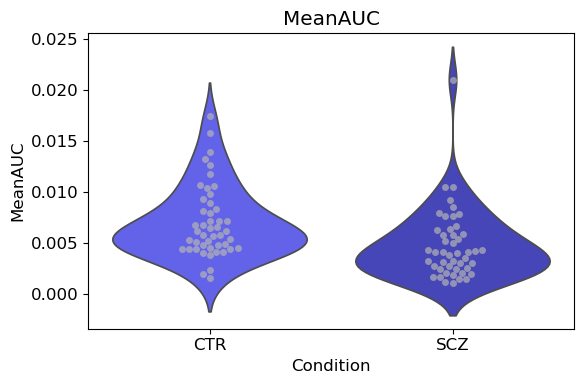

In [69]:
cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]]
cols2 = [[0.7,0.7,1],[0.6,0.6,1],[0.5,0.5,1],[0.4,0.4,1]]

plt.figure(figsize=(6, 4))

# Extract data for the specific component across conditions and subjects
# mean_auc shape (n_sub, n_cond)

# Create DataFrame for violin plot
mean_auc_tmp = {
    'Condition': np.tile(conds, n_sub),
    'MeanAUC': mean_auc.flatten()
}

mean_auc_df = pd.DataFrame(mean_auc_tmp)
# Violin plot
sb.violinplot(data=mean_auc_df, x='Condition', y='MeanAUC', inner=None, palette=cols)
sb.swarmplot(data=mean_auc_df, x='Condition', y='MeanAUC', color=[0.7,0.7,0.7], alpha=0.7)
# Formatting the plot
plt.xlabel("Condition")
plt.ylabel("MeanAUC")
plt.title(f"MeanAUC")
#plt.grid(True, linestyle='--', alpha=0.6)
# Show the plot
plt.tight_layout()

plt.savefig(os.path.join(res_dir, 'Mean_AUC.jpg'), format='jpg', dpi=300)

In [70]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Step 1: Flatten the mean and std arrays
mean_flat_auc = mean_auc.flatten()
std_flat_auc = std_auc.flatten()
var_flat = std_flat_auc ** 2

# Step 2: Create group labels: 0 for CTR, 1 for SCZ
condition = np.array([0]*47 + [1]*47)

# Step 3: Build design matrix (intercept + condition dummy)
X = sm.add_constant(condition)  # adds column of 1s for intercept

# Step 4: Fit weighted least squares model
wls_model = sm.WLS(mean_flat_auc, X, weights=1/var_flat)
results = wls_model.fit()

# Step 5: Print summary and interpret
print(results.summary())

# Extract condition effect and p-value
beta = results.params[1]
p_value = results.pvalues[1]

print(f"\nEstimated difference in mean latency (SCZ - CTR): {beta:.3f}")
print(f"p-value for group difference: {p_value:.4f}")
if p_value < 0.05:
    print("✅ Statistically significant difference between groups.")
else:
    print("❌ No statistically significant difference between groups.")


                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            WLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.4415
Date:                Fri, 11 Apr 2025   Prob (F-statistic):              0.508
Time:                        14:07:01   Log-Likelihood:                 416.83
No. Observations:                  94   AIC:                            -829.7
Df Residuals:                      92   BIC:                            -824.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.000      9.644      0.0

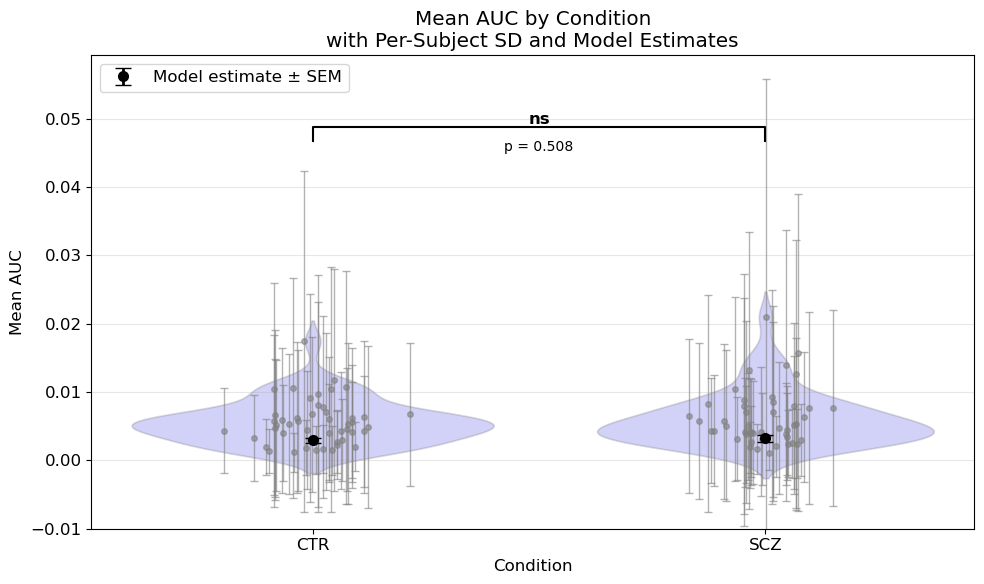

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Prepare flattened data
mean_flat_auc = mean_auc.flatten()
std_flat_auc = std_auc.flatten()
group_labels = np.array(['CTR']*47 + ['SCZ']*47)

# Create DataFrame for plotting
data = pd.DataFrame({
    'Condition': group_labels,
    'Mean_AUC': mean_flat_auc,
    'Std_AUC': std_flat_auc
})

# Calculate model-estimated means and SEMs from WLS
intercept = results.params[0]         # Mean for CTR
diff = results.params[1]              # SCZ - CTR
scz_mean = intercept + diff
stderr_ctr = results.bse[0]
stderr_diff = results.bse[1]
stderr_scz = np.sqrt(stderr_ctr**2 + stderr_diff**2)

# Violin plot (distribution shape only)
plt.figure(figsize=(10, 6))
sns.violinplot(data=data, x='Condition', y='Mean_AUC',
               inner=None, color='blue', alpha=0.2)

# Jittered individual data points with SD error bars
rng = np.random.default_rng(42)
jitter_strength = 0.1
x_positions = data['Condition'].map({'CTR': 0, 'SCZ': 1}).values
x_jittered = x_positions + rng.normal(0, jitter_strength, size=len(x_positions))

plt.errorbar(x=x_jittered,
             y=data['Mean_AUC'],
             yerr=data['Std_AUC'],
             fmt='o',
             ecolor='gray',
             elinewidth=1,
             capsize=3,
             markersize=4,
             color='gray',
             alpha=0.6)

# Overlay model-estimated means ± SEM
x_model = [0, 1]
y_model = [intercept, scz_mean]
yerr_model = [stderr_ctr, stderr_scz]

plt.errorbar(x=x_model,
             y=y_model,
             yerr=yerr_model,
             fmt='o',
             color='black',
             capsize=6,
             markersize=7,
             linewidth=2,
             label='Model estimate ± SEM',
             zorder=10)

# Add significance bar and annotation
def improved_stat_annotation(p_value):
    if p_value < 0.001:
        star_string = '***'
    elif p_value < 0.01:
        star_string = '**'
    elif p_value < 0.05:
        star_string = '*'
    else:
        star_string = 'ns'
    
    y_max = (data['Mean_AUC'] + data['Std_AUC']).max()
    y_top = max(y_max, max(y_model) + max(yerr_model))
    bar_height = y_top - 0.009

    plt.plot([0, 0, 1, 1], 
             [bar_height, bar_height + 0.002, bar_height + 0.002, bar_height],
             'k-', linewidth=1.5)

    plt.text(0.5, bar_height + 0.002, star_string,
             ha='center', va='bottom', fontsize=12, fontweight='bold')
    plt.text(0.5, bar_height - 0.002, f'p = {p_value:.3f}',
             ha='center', va='bottom', fontsize=10)

# Add significance stars
improved_stat_annotation(p_value)

# Final touches
plt.title('Mean AUC by Condition\nwith Per-Subject SD and Model Estimates')
plt.ylabel('Mean AUC')
plt.xlabel('Condition')
plt.grid(axis='y', alpha=0.3)
plt.ylim(-0.01, plt.ylim()[1])
plt.tight_layout()
plt.legend()

plt.savefig(os.path.join(res_dir, 'MeanAUC_stat_test.jpg'), format='jpg', dpi=300)


# See if there is a relation between Entropy Production and AUC/Latency

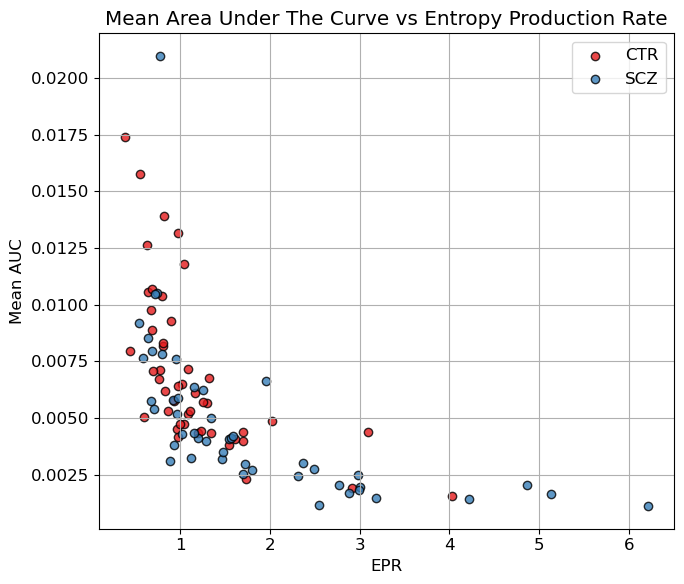

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#sns.set_style("whitegrid")  # get white background + grid

# Flatten the (47, 2) arrays into (94,) vectors
x = EPR.flatten()
y = mean_auc.flatten()
conditions = np.tile([0, 1], 47)

# Plot
plt.figure(figsize=(7, 6))
palette = sns.color_palette("Set1", 2)
labels = {0: "CTR", 1: "SCZ"}
for cond in [0, 1]:
    plt.scatter(
        x[conditions == cond],
        y[conditions == cond],
        label=labels[cond],
        color=palette[cond],
        alpha=0.8,
        edgecolor='k'
    )

plt.xlabel('EPR')
plt.ylabel('Mean AUC')
plt.title('Mean Area Under The Curve vs Entropy Production Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig(os.path.join(res_dir, 'MeanAUC_EPR.jpg'), format='jpg', dpi=300)


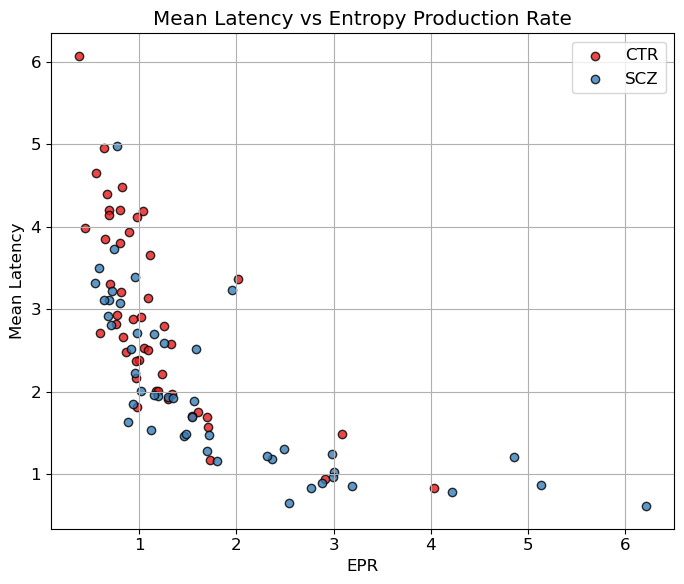

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#sns.set_style("whitegrid")  # Background

# Flatten the (47, 2) arrays into (94,) vectors
x = EPR.flatten()
y = mean_latency.flatten()
y_std = std_latency.flatten()
conditions = np.tile([0, 1], 47)

# Plot
plt.figure(figsize=(7, 6))
palette = sns.color_palette("Set1", 2)
labels = {0: "CTR", 1: "SCZ"}
for cond in [0, 1]:
    plt.scatter(
        x[conditions == cond],
        y[conditions == cond],
        label=labels[cond],
        color=palette[cond],
        alpha=0.8,
        edgecolor='k'
    )

plt.xlabel('EPR')
plt.ylabel('Mean Latency')
plt.title('Mean Latency vs Entropy Production Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig(os.path.join(res_dir, 'MeanLatency_EPR.jpg'), format='jpg', dpi=300)

# Fit two exponentials for the Mean Latency:

$y = a*e^{bx}$

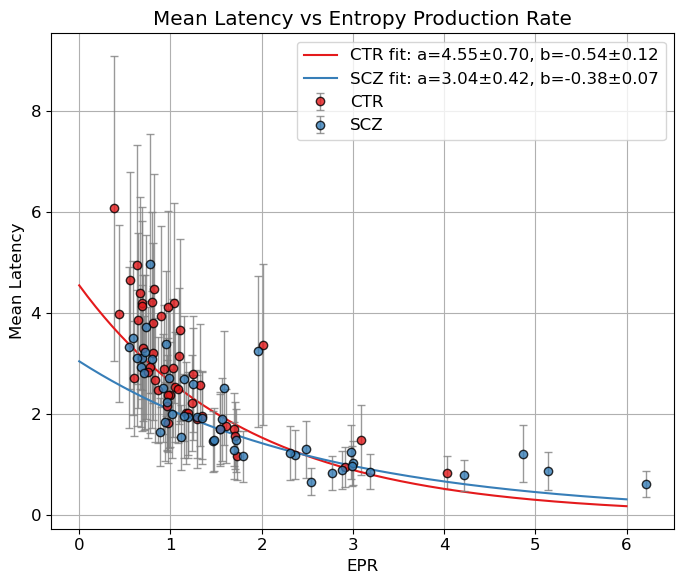

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit
import os

# Define the exponential model
def exp_model(x, a, b):
    return a * np.exp(b * x)

# Flatten arrays and define condition labels
x = EPR.flatten()
y = mean_latency.flatten()
y_std = std_latency.flatten()
conditions = np.tile([0, 1], 47)  # 47 samples per group

# Plot setup
plt.figure(figsize=(7, 6))
palette = sns.color_palette("Set1", 2)
labels = {0: "CTR", 1: "SCZ"}

# Loop over conditions
for cond in [0, 1]:
    x_cond = x[conditions == cond]
    y_cond = y[conditions == cond]
    yerr_cond = y_std[conditions == cond]

    # Errorbar plot (instead of scatter)
    plt.errorbar(
        x_cond, y_cond, yerr=yerr_cond,
        fmt='o',
        label=labels[cond],
        color=palette[cond],
        alpha=0.8,
        ecolor='gray',
        elinewidth=1,
        capsize=3,
        markeredgecolor='k'
    )

    # Fit
    popt, pcov = curve_fit(exp_model, x_cond, y_cond, sigma=yerr_cond, absolute_sigma=True)
    perr = np.sqrt(np.diag(pcov))

    # Fit curve
    x_fit = np.linspace(0, 6, 200)
    y_fit = exp_model(x_fit, *popt)

    # Plot fit line
    label_fit = f'{labels[cond]} fit: a={popt[0]:.2f}±{perr[0]:.2f}, b={popt[1]:.2f}±{perr[1]:.2f}'
    plt.plot(x_fit, y_fit, color=palette[cond], linestyle='-', label=label_fit)

# Labels and layout
plt.xlabel('EPR')
plt.ylabel('Mean Latency')
plt.title('Mean Latency vs Entropy Production Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save plot
plt.savefig(os.path.join(res_dir, 'FitErr_MeanLatency_EPR.jpg'), format='jpg', dpi=300)


In [75]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


Comparison between: 
- b[scz] vs b[ctr] 
- a[scz] vs a[ctr]

In [76]:
from tqdm import tqdm  # For progress bar
import numpy as np
from scipy.optimize import curve_fit

np.random.seed(42)  # For reproducibility

n_bootstrap = 1000
a_bootstrap = {0: [], 1: []}
b_bootstrap = {0: [], 1: []}

# Bootstrap loop
for cond in [0, 1]:
    x_cond = x[conditions == cond]
    y_cond = y[conditions == cond]
    yerr_cond = y_std[conditions == cond]
    n_samples = len(x_cond)

    for _ in tqdm(range(n_bootstrap), desc=f"Bootstrapping {labels[cond]}"):
        # Resample indices with replacement
        idx = np.random.choice(n_samples, size=n_samples, replace=True)
        x_resampled = x_cond[idx]
        y_resampled = y_cond[idx]
        yerr_resampled = yerr_cond[idx]

        # Try fitting; skip if it fails (rare)
        try:
            popt, _ = curve_fit(
                exp_model,
                x_resampled,
                y_resampled,
                sigma=yerr_resampled,
                absolute_sigma=True,
                maxfev=10000
            )
            a_bootstrap[cond].append(popt[0])  # store a
            b_bootstrap[cond].append(popt[1])  # store b
        except RuntimeError:
            continue  # skip failed fits

# Convert to numpy arrays
a_ctr, a_scz = np.array(a_bootstrap[0]), np.array(a_bootstrap[1])
b_ctr, b_scz = np.array(b_bootstrap[0]), np.array(b_bootstrap[1])

# Compute difference distributions
a_diff = a_ctr - a_scz
b_diff = b_ctr - b_scz

# Compute two-tailed p-values
p_value_a = 2 * np.mean(np.abs(a_diff) > np.abs(np.mean(a_diff)))
p_value_b = 2 * np.mean(np.abs(b_diff) > np.abs(np.mean(b_diff)))

# Summary output
print(f"\nBootstrap results:")
print(f"Parameter a:")
print(f"Mean a_CTR = {np.mean(a_ctr):.4f} ± {np.std(a_ctr):.4f}")
print(f"Mean a_SCZ = {np.mean(a_scz):.4f} ± {np.std(a_scz):.4f}")
print(f"Mean Δa = {np.mean(a_diff):.4f}")
print(f"p-value for a_CTR ≠ a_SCZ: {p_value_a:.4f}")
if p_value_a < 0.05:
    print("✅ Statistically significant difference between the a parameters.")
else:
    print("❌ No statistically significant difference between the a parameters.")

print(f"\nParameter b:")
print(f"Mean b_CTR = {np.mean(b_ctr):.4f} ± {np.std(b_ctr):.4f}")
print(f"Mean b_SCZ = {np.mean(b_scz):.4f} ± {np.std(b_scz):.4f}")
print(f"Mean Δb = {np.mean(b_diff):.4f}")
print(f"p-value for b_CTR ≠ b_SCZ: {p_value_b:.4f}")
if p_value_b < 0.05:
    print("✅ Statistically significant difference between the b parameters.")
else:
    print("❌ No statistically significant difference between the b parameters.")


Bootstrapping SCZ: 100%|██████████| 1000/1000 [00:00<00:00, 1438.09it/s]


Bootstrap results:
Parameter a:
Mean a_CTR = 4.7357 ± 0.6112
Mean a_SCZ = 3.1101 ± 0.4072
Mean Δa = 1.6256
p-value for a_CTR ≠ a_SCZ: 0.9200
❌ No statistically significant difference between the a parameters.

Parameter b:
Mean b_CTR = -0.5712 ± 0.1109
Mean b_SCZ = -0.3876 ± 0.0781
Mean Δb = -0.1835
p-value for b_CTR ≠ b_SCZ: 0.9320
❌ No statistically significant difference between the b parameters.


# Fit the two exponentials for AUC:
$y = a*e^{bx}$

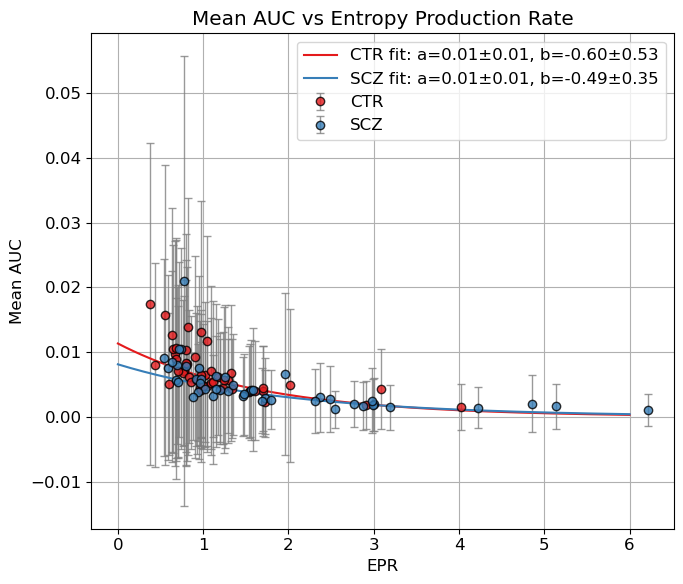

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit
import os

# Define the exponential model
def exp_model(x_auc, a, b):
    return a * np.exp(b * x_auc)

# Flatten arrays and define condition labels
x_auc = EPR.flatten()
y_auc = mean_auc.flatten()
y_std_auc = std_auc.flatten()
conditions = np.tile([0, 1], 47)  # 47 samples per group

# Plot setup
plt.figure(figsize=(7, 6))
palette = sns.color_palette("Set1", 2)
labels = {0: "CTR", 1: "SCZ"}

# Loop over conditions
for cond in [0, 1]:
    x_cond = x_auc[conditions == cond]
    y_cond = y_auc[conditions == cond]
    yerr_cond = y_std_auc[conditions == cond]

    # Errorbar plot (instead of scatter)
    plt.errorbar(
        x_cond, y_cond, yerr=yerr_cond,
        fmt='o',
        label=labels[cond],
        color=palette[cond],
        alpha=0.8,
        ecolor='gray',
        elinewidth=1,
        capsize=3,
        markeredgecolor='k'
    )

    # Fit
    popt, pcov = curve_fit(exp_model, x_cond, y_cond, sigma=yerr_cond, absolute_sigma=True)
    perr = np.sqrt(np.diag(pcov))

    # Fit curve
    x_fit = np.linspace(0, 6, 200)
    y_fit = exp_model(x_fit, *popt)

    # Plot fit line
    label_fit = f'{labels[cond]} fit: a={popt[0]:.2f}±{perr[0]:.2f}, b={popt[1]:.2f}±{perr[1]:.2f}'
    plt.plot(x_fit, y_fit, color=palette[cond], linestyle='-', label=label_fit)

# Labels and layout
plt.xlabel('EPR')
plt.ylabel('Mean AUC')
plt.title('Mean AUC vs Entropy Production Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save plot
plt.savefig(os.path.join(res_dir, 'FitErr_MeanAUC_EPR.jpg'), format='jpg', dpi=300)


Comparison between: 
- b[scz] vs b[ctr] 
- a[scz] vs a[ctr]

In [78]:
from tqdm import tqdm  # For progress bar
import numpy as np
from scipy.optimize import curve_fit

np.random.seed(42)  # For reproducibility

n_bootstrap = 1000
a_bootstrap = {0: [], 1: []}
b_bootstrap = {0: [], 1: []}

# Bootstrap loop
for cond in [0, 1]:
    x_cond = x_auc[conditions == cond]
    y_cond = y_auc[conditions == cond]
    yerr_cond = y_std_auc[conditions == cond]
    n_samples = len(x_cond)

    for _ in tqdm(range(n_bootstrap), desc=f"Bootstrapping {labels[cond]}"):
        # Resample indices with replacement
        idx = np.random.choice(n_samples, size=n_samples, replace=True)
        x_resampled = x_cond[idx]
        y_resampled = y_cond[idx]
        yerr_resampled = yerr_cond[idx]

        # Try fitting; skip if it fails (rare)
        try:
            popt, _ = curve_fit(
                exp_model,
                x_resampled,
                y_resampled,
                sigma=yerr_resampled,
                absolute_sigma=True,
                maxfev=10000
            )
            a_bootstrap[cond].append(popt[0])  # store a
            b_bootstrap[cond].append(popt[1])  # store b
        except RuntimeError:
            continue  # skip failed fits

# Convert to numpy arrays
a_ctr, a_scz = np.array(a_bootstrap[0]), np.array(a_bootstrap[1])
b_ctr, b_scz = np.array(b_bootstrap[0]), np.array(b_bootstrap[1])

# Compute difference distributions
a_diff = a_ctr - a_scz
b_diff = b_ctr - b_scz

# Compute two-tailed p-values
p_value_a = 2 * np.mean(np.abs(a_diff) > np.abs(np.mean(a_diff)))
p_value_b = 2 * np.mean(np.abs(b_diff) > np.abs(np.mean(b_diff)))

# Summary output
print(f"\nBootstrap results:")
print(f"Parameter a:")
print(f"Mean a_CTR = {np.mean(a_ctr):.4f} ± {np.std(a_ctr):.4f}")
print(f"Mean a_SCZ = {np.mean(a_scz):.4f} ± {np.std(a_scz):.4f}")
print(f"Mean Δa = {np.mean(a_diff):.4f}")
print(f"p-value for a_CTR ≠ a_SCZ: {p_value_a:.4f}")
if p_value_a < 0.05:
    print("✅ Statistically significant difference between the a parameters.")
else:
    print("❌ No statistically significant difference between the a parameters.")

print(f"\nParameter b:")
print(f"Mean b_CTR = {np.mean(b_ctr):.4f} ± {np.std(b_ctr):.4f}")
print(f"Mean b_SCZ = {np.mean(b_scz):.4f} ± {np.std(b_scz):.4f}")
print(f"Mean Δb = {np.mean(b_diff):.4f}")
print(f"p-value for b_CTR ≠ b_SCZ: {p_value_b:.4f}")
if p_value_b < 0.05:
    print("✅ Statistically significant difference between the b parameters.")
else:
    print("❌ No statistically significant difference between the b parameters.")


Bootstrapping SCZ: 100%|██████████| 1000/1000 [00:00<00:00, 1394.42it/s]


Bootstrap results:
Parameter a:
Mean a_CTR = 0.0118 ± 0.0020
Mean a_SCZ = 0.0083 ± 0.0013
Mean Δa = 0.0035
p-value for a_CTR ≠ a_SCZ: 0.9120
❌ No statistically significant difference between the a parameters.

Parameter b:
Mean b_CTR = -0.6228 ± 0.1407
Mean b_SCZ = -0.4986 ± 0.0952
Mean Δb = -0.1241
p-value for b_CTR ≠ b_SCZ: 1.0520
❌ No statistically significant difference between the b parameters.


## Statistical test on latency and auc MATRICES

In [79]:
import numpy as np
import scipy.stats as stats
import statsmodels.stats.multitest as smm
import pandas as pd

# Parameters
n_sub = 47  # Number of patients per condition
N = 68  # Brain regions

# Initialize lists to store results for each (i, j) brain region pair
p_values_list_latency = []
test_used_list_latency = []
p_values_list_auc = []
test_used_list_auc = []
region_1_list = []
region_2_list = []
latency_diff_list = []
auc_diff_list = []


# Perform statistical tests for each (i, j) region pair
for i in range(N):
    for j in range(N):
        try:
            # Extract data for the two conditions
            group_0_latency = latency[:, 0, i, j]  # Control group
            group_1_latency = latency[:, 1, i, j]  # Schizophrenic group
            group_0_auc = auc[:, 0, i, j]
            group_1_auc = auc[:, 1, i, j]
        except IndexError:
            print(f"IndexError at (i={i}, j={j}) - Check latency and auc dimensions")
            continue
        
        # Check if the data has zero variance (all values are the same)
        if np.all(group_0_latency == group_0_latency[0]) or np.all(group_1_latency == group_1_latency[0]):
            p_latency = 1.0  # No difference if variance is zero
            test_used_latency = "Skipped (zero variance)"
        else:
            p_latency = stats.mannwhitneyu(group_0_latency, group_1_latency, alternative='two-sided').pvalue
            test_used_latency = "Mann-Whitney U"
        
        if np.all(group_0_auc == group_0_auc[0]) or np.all(group_1_auc == group_1_auc[0]):
            p_auc = 1.0  # No difference if variance is zero
            test_used_auc = "Skipped (zero variance)"
        else:
            p_auc = stats.mannwhitneyu(group_0_auc, group_1_auc, alternative='two-sided').pvalue
            test_used_auc = "Mann-Whitney U"

        latency_diff = np.mean(group_0_latency) - np.mean(group_1_latency)
        auc_diff = np.mean(group_0_auc) - np.mean(group_1_auc)
        
        # Store results
        p_values_list_latency.append(p_latency)
        test_used_list_latency.append(test_used_latency)
        p_values_list_auc.append(p_auc)
        test_used_list_auc.append(test_used_auc)
        region_1_list.append(i)
        region_2_list.append(j)
        latency_diff_list.append(latency_diff)
        auc_diff_list.append(auc_diff)

# Convert p-values to numpy array for multiple comparison correction
p_values_array_latency = np.array(p_values_list_latency)
p_values_array_auc = np.array(p_values_list_auc)

# Apply FDR correction (Benjamini-Hochberg)
_, p_corrected_latency, _, _ = smm.multipletests(p_values_array_latency, alpha=0.05, method='bonferroni')
_, p_corrected_auc, _, _ = smm.multipletests(p_values_array_auc, alpha=0.05, method='bonferroni')

# Store results in DataFrames
results_df_latency = pd.DataFrame({
    "Brain Region 1": region_1_list,
    "Brain Region 2": region_2_list,
    "p-value": p_values_list_latency,
    "corrected p-value": p_corrected_latency,
    "Test Used": test_used_list_latency,
    "Mean Difference": latency_diff_list
})

results_df_auc = pd.DataFrame({
    "Brain Region 1": region_1_list,
    "Brain Region 2": region_2_list,
    "p-value": p_values_list_auc,
    "corrected p-value": p_corrected_auc,
    "Test Used": test_used_list_auc,
    "Mean Difference": auc_diff_list
})

# Filter significant brain region pairs based on FDR correction
significant_latency = results_df_latency[results_df_latency["corrected p-value"] < 0.05]
significant_auc = results_df_auc[results_df_auc["corrected p-value"] < 0.05]

# Save results as .npy files
np.save(os.path.join(res_dir, f'latency.npy'), results_df_latency.to_dict(orient="list"))
np.save(os.path.join(res_dir, f'auc.npy'), results_df_auc.to_dict(orient="list"))

# Print results
print("\nSignificant Brain Region Pairs for Latency (after correction):")
print(len(significant_latency[["Brain Region 1", "Brain Region 2", "Mean Difference"]].values.tolist()))
print(significant_latency[["Brain Region 1", "Brain Region 2", "Mean Difference"]].values.tolist())
print("\nSignificant Brain Region Pairs for AUC (after correction):")
print(len(significant_auc[["Brain Region 1", "Brain Region 2", "Mean Difference"]].values.tolist()))
print(significant_auc[["Brain Region 1", "Brain Region 2", "Mean Difference"]].values.tolist())



Significant Brain Region Pairs for Latency (after correction):
77
[[0.0, 28.0, 0.9914893617021276], [3.0, 21.0, 1.6446808510638293], [4.0, 35.0, 1.3021276595744673], [4.0, 42.0, 1.4191489361702132], [5.0, 22.0, 1.5489361702127666], [5.0, 26.0, 1.8765957446808499], [7.0, 43.0, 1.5765957446808507], [8.0, 16.0, 1.3638297872340428], [9.0, 56.0, 1.5127659574468078], [11.0, 15.0, 1.5170212765957451], [11.0, 63.0, 1.702127659574468], [15.0, 60.0, 1.4319148936170214], [17.0, 38.0, 1.2702127659574471], [18.0, 30.0, 1.285106382978724], [19.0, 56.0, 1.5361702127659584], [19.0, 63.0, 1.7999999999999994], [22.0, 5.0, 1.459574468085107], [22.0, 44.0, 1.6148936170212762], [22.0, 52.0, 1.7063829787234053], [22.0, 60.0, 1.806382978723405], [28.0, 42.0, 1.251063829787234], [30.0, 2.0, 1.2787234042553193], [30.0, 16.0, 1.3914893617021273], [30.0, 18.0, 1.48936170212766], [32.0, 50.0, 1.563829787234043], [32.0, 52.0, 1.580851063829787], [33.0, 17.0, 1.3765957446808519], [34.0, 8.0, 1.174468085106383], [3

Good, using BONFERRONI = conservative towards type I errors, I get some statistical significant results

In [80]:
significant_latency

,Brain Region 1,Brain Region 2,p-value,corrected p-value,Test Used,Mean Difference
28,0,28,8.696995e-07,0.004021,Mann-Whitney U,0.991489
225,3,21,8.358298e-06,0.038649,Mann-Whitney U,1.644681
307,4,35,4.543538e-06,0.021009,Mann-Whitney U,1.302128
314,4,42,6.412226e-06,0.029650,Mann-Whitney U,1.419149
362,5,22,2.727459e-06,0.012612,Mann-Whitney U,1.548936
...,...,...,...,...,...,...
4336,63,52,2.973412e-06,0.013749,Mann-Whitney U,1.578723
4344,63,60,3.044658e-06,0.014078,Mann-Whitney U,1.702128
4565,67,9,8.365833e-06,0.038684,Mann-Whitney U,1.672340
4600,67,44,1.066786e-05,0.049328,Mann-Whitney U,1.714894


In [81]:
# Initialize empty connection matrices
latency_conn_diff = np.zeros((N, N))
auc_conn_diff = np.zeros((N, N))

# Fill in only significant entries
for _, row in significant_latency.iterrows():
    i = int(row["Brain Region 1"])
    j = int(row["Brain Region 2"])
    latency_conn_diff[i, j] = row["Mean Difference"]

for _, row in significant_auc.iterrows():
    i = int(row["Brain Region 1"])
    j = int(row["Brain Region 2"])
    auc_conn_diff[i, j] = row["Mean Difference"]

In [82]:
import numpy as np
import pandas as pd

# Path to your .node file
node_file = './Desikan-Killiany68.node'  # or use '/mnt/data/Desikan-Killiany68.node' if in notebook

# Step 1: Read the file and skip the header
with open(node_file, 'r') as f:
    lines = f.readlines()

# Step 2: Parse each line (excluding header)
data_lines = lines[1:]  # skip header, typically 'nodes'

# Step 3: Split lines and extract coordinates + labels
coords = []
labels = []

for line in data_lines:
    parts = line.strip().split()
    if len(parts) >= 5:
        x, y, z = map(float, parts[:3])
        label = parts[-1]
        coords.append([x, y, z])
        labels.append(label)
    else:
        print(f"Warning: malformed line skipped -> {line}")

coords = np.array(coords)  # shape (68, 3)

# Step 4: Wrap into a DataFrame for easy inspection
df_node = pd.DataFrame(coords, columns=['x', 'y', 'z'])
df_node['Label'] = labels

# Step 5: Show first few rows to verify
print(df_node.head())

# Optional: Save to CSV for manual inspection
# df_node.to_csv("parsed_node_file.csv", index=False)


           x          y          z                      Label
0 -54.343785 -44.539029   4.163784                 l.bankssts
1  -5.030493  20.087970  28.999343  l.caudalanteriorcingulate
2 -35.521824  10.809538  44.190969      l.caudalmiddlefrontal
3  -7.126394 -79.633054  18.510034                   l.cuneus
4 -22.998997  -7.877750 -35.210045               l.entorhinal


In [83]:

# Extract non-zero (i, j) indices and corresponding differences
nonzero_indices_latency = significant_latency[["Brain Region 1", "Brain Region 2"]].values
nonzero_indices_auc = significant_auc[["Brain Region 1", "Brain Region 2"]].values

# Step 4: Extract labeled connections
significant_connections_latency = []
for i, j in nonzero_indices_latency:
    region_i = labels[i]
    region_j = labels[j]
    diff = latency_conn_diff[i, j]
    significant_connections_latency.append((region_i, region_j, diff))
significant_latency_df = pd.DataFrame(significant_connections_latency, columns=["Region 1", "Region 2", "Mean Latency Difference"])

# Step 4: Extract labeled connections
significant_connections_auc = []
for i, j in nonzero_indices_auc:
    region_i = labels[i]
    region_j = labels[j]
    diff = auc_conn_diff[i, j]
    significant_connections_auc.append((region_i, region_j, diff))
significant_auc_df = pd.DataFrame(significant_connections_auc, columns=["Region 1", "Region 2", "Mean Auc Difference"])

In [84]:
labels[0]

'l.bankssts'

In [85]:
print(significant_auc_df)

                     Region 1              Region 2  Mean Auc Difference
0   l.caudalanteriorcingulate     l.parsopercularis             0.005547
1             l.supramarginal              r.insula             0.002550
2                    l.insula              r.insula             0.003952
3       r.caudalmiddlefrontal       l.supramarginal             0.004224
4       r.caudalmiddlefrontal    r.isthmuscingulate             0.004609
5       r.caudalmiddlefrontal              r.insula             0.003119
6          r.inferiorparietal              r.insula             0.001144
7          r.isthmuscingulate       l.supramarginal             0.003613
8          r.isthmuscingulate            r.bankssts             0.008436
9          r.isthmuscingulate              r.insula             0.003728
10                r.precuneus    l.parstriangularis             0.006940
11                r.precuneus  l.posteriorcingulate             0.004177
12                r.precuneus     l.superiorfrontal

In [86]:
print(significant_latency_df)

           Region 1                   Region 2  Mean Latency Difference
0        l.bankssts         l.superiortemporal                 0.991489
1          l.cuneus       l.posteriorcingulate                 1.644681
2      l.entorhinal  r.caudalanteriorcingulate                 1.302128
3      l.entorhinal         r.isthmuscingulate                 1.419149
4        l.fusiform               l.precentral                 1.548936
..              ...                        ...                      ...
72  r.supramarginal         r.parstriangularis                 1.578723
73  r.supramarginal          r.superiorfrontal                 1.702128
74         r.insula         l.lateraloccipital                 1.672340
75         r.insula     r.lateralorbitofrontal                 1.714894
76         r.insula         r.parstriangularis                 1.723404

[77 rows x 3 columns]


In [87]:
# Save
significant_latency_df.to_pickle(os.path.join(res_dir, "significant_latency_df.pkl"))
significant_auc_df.to_pickle(os.path.join(res_dir, "significant_auc_df.pkl"))

In [88]:
# Export to Latex

with open(os.path.join(res_dir, "significant_latency_table.tex"), "w") as f:
    f.write(significant_latency_df.to_latex(index=False, float_format="%.4f", caption="Significant Brain Region Pairs (Latency)", label="tab:significant_latency"))

with open(os.path.join(res_dir, "significant_auc_table.tex"), "w") as f:
    f.write(significant_auc_df.to_latex(index=False, float_format="%.4f", caption="Significant Brain Region Pairs (AUC)", label="tab:significant_auc"))


# ?? There is not a way to plot the brain with the directionality??

Suggestion: Network X

In [89]:
import numpy as np
import pandas as pd
import os
from nilearn import plotting
def symmetrize(conn_matrix): 
    conn_matrix_symm = (conn_matrix + conn_matrix.T) / 2  # make symmetric
    np.fill_diagonal(conn_matrix_symm, 0)
    return conn_matrix_symm

# Plot the connectome
view = plotting.view_connectome(symmetrize(latency_conn_diff), coords, edge_threshold='90%')
view.open_in_browser()


Gtk-Message: 14:07:18.876: Not loading module "atk-bridge": The functionality is provided by GTK natively. Please try to not load it.
[23358, Main Thread] WARNING: GTK+ module /snap/firefox/5947/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.: 'glib warning', file /build/firefox/parts/firefox/build/toolkit/xre/nsSigHandlers.cpp:201

(firefox_firefox:23358): Gtk-WARNING **: 14:07:19.020: GTK+ module /snap/firefox/5947/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.
Gtk-Message: 14:07:19.020: Failed to load module "canberra-gtk-module"
[23358, Main Thread] WARNING: GTK+ module /snap/firefox/5947/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same

In [90]:
view = plotting.view_connectome(symmetrize(auc_conn_diff), coords, edge_threshold='90%')
view.open_in_browser()

Gtk-Message: 14:07:19.688: Not loading module "atk-bridge": The functionality is provided by GTK natively. Please try to not load it.
[23460, Main Thread] WARNING: GTK+ module /snap/firefox/5947/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.: 'glib warning', file /build/firefox/parts/firefox/build/toolkit/xre/nsSigHandlers.cpp:201

(firefox_firefox:23460): Gtk-WARNING **: 14:07:19.804: GTK+ module /snap/firefox/5947/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.
Gtk-Message: 14:07:19.804: Failed to load module "canberra-gtk-module"
[23460, Main Thread] WARNING: GTK+ module /snap/firefox/5947/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same